# Import dependencies

In [1]:
import torch
import cv2
import numpy as np
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import torch.optim.lr_scheduler as lr_scheduler
import random
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
from os import path
from PIL import Image
%matplotlib inline

# Define configurations
Set `TEST` to `True` to test the model behavior.
Make sure checkpoint is avaliable.
Reuse validation variables in testing.

In [2]:
# model
out_dim = 8
num_features = 8
use_apex = True # If you haven't install apex, turn false, see more details on 
                # https://github.com/NVIDIA/apex

# environment
device = 'cuda' # if don't have GPU, turn 'cpu'
random_seed = 0

# dataset
label_csv_path = '/home/dw-dengwei/dataset/tissue/train.csv'
image_root = '/home/dw-dengwei/dataset/tissue/train/'

# experiment
train_batch_size = 128
valid_batch_size = 128
epoch_num = 100
learning_rate = 0.025336627337952815
weight_decay =  0.0046684446208345
training_ratio = 0.8
save_path = "save/checkpoint_batchsize128.pth"
TEST = False

# SGD optimizer
momentum =  0.8
nesterov = True

# scheduler
patience = 5
factor = 0.29

# Setup

In [3]:
# fix random seed
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# load label and id into memory
label_dataframe = pd.read_csv(label_csv_path)
label_db = {}
ids = []
for index, rows in label_dataframe.iterrows():
    idx, label = rows['Id'], rows['Cell type']
    label_db[str(idx)] = label
    ids.append(str(idx))

# ids = ids[:10]

# split training set and validation set
n = len(ids)
train_ids = random.sample(ids, k=int(n * training_ratio))
valid_ids = list(set(ids) - set(train_ids))

# import apex
if use_apex:
    from apex import amp

# Define essential classes and functions

In [4]:
# Dataset class
class Cell(Dataset):
    def __init__(self, 
                 ids: list, 
                 label_db: dict, 
                 image_root: str, 
        ) -> None:
        '''
        ids: indexes of the training/validating data
        label_db: dict structure of train.csv file
        image_root: image root path
        '''

        self.num = len(ids)
        self.label = []
        self.image = []

        # These operations may cause large memory in runtime and time use at start.
        # Using database file is recommended.
        for idx in ids:
            target = label_db[idx]
            img_cv = cv2.imread(path.join(image_root, str(idx).rjust(6, '0') + ".jpg"))
            img = self.transform(img_cv)
            self.label.append(target)
            self.image.append(img)

    def __len__(self) -> int:
        return self.num

    def __getitem__(self, index):
        return self.image[index], self.label[index]

    def transform(self, img_cv) -> torch.Tensor:
        img_pil = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
        tf = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x[0:1, :, :]),
            ])
        return tf(img_pil)


# model structure
class Toy(nn.Module):
    def __init__(self, num_feature, num_classes):
        super().__init__()
        self.num_feature=num_feature
        self.layer = nn.Sequential(
            self.make_layer(1, self.num_feature, is_pooling=False),
            self.make_layer(self.num_feature, self.num_feature, is_pooling=False),
            self.make_layer(self.num_feature, self.num_feature, is_pooling=False),

            self.make_layer(self.num_feature, self.num_feature * 2),
            self.make_layer(self.num_feature * 2, self.num_feature * 2, is_pooling=False),

            self.make_layer(self.num_feature * 2, self.num_feature * 4),

            self.make_layer(self.num_feature * 4, self.num_feature * 8),

            self.make_layer(self.num_feature * 8, self.num_feature * 16, is_pooling=False),
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(self.num_feature * 16 * 3 * 3, self.num_feature * 16),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(self.num_feature * 16, num_classes)
        )    
                
        
    def make_layer(self, 
                   in_channels, 
                   out_channels,
                   is_pooling=True,
                   kernel_size=3, 
                   stride=1, 
                   padding=1):
        layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        if is_pooling:
            layers.add_module('pooling', nn.AvgPool2d(2, 2))
        return layers


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer(x)
        x = x.view(x.size()[0], -1)
        x = self.fc_layer(x)
        return x

# Training and valitation

In [5]:
def train_epoch(model: nn.Module, epoch: int, dataloader: DataLoader, optimizer, device):
    model.train()
    pred_true = 0
    pred_tot = 0
    loss_sum = 0
    verbose = 10

    batch_acc = []
    batch_loss = []

    # train batch
    for iter, batch in enumerate(dataloader):
        image, label = batch
        image = image.to(torch.device(device))
        label = label.to(torch.device(device))
        predict = model.forward(image)
        loss = F.cross_entropy(predict, label)

        optimizer.zero_grad()
        if use_apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()

        optimizer.step()

        _, pred_class = predict.max(1)
        pred_true += (label == pred_class).sum()
        pred_tot += label.size(0)
        loss_sum += loss.item()
        acc = (label == pred_class).sum() / label.size(0)
        batch_acc.append(acc)
        batch_loss.append(loss)
        if (iter + 1) % verbose == 0:
            print("[Train:{}-{}/{}]\tAcc:{}\tLoss:{}".format( 
                  epoch, 
                  iter, 
                  len(dataloader), 
                  acc, 
                  loss))

    epoch_acc = pred_true / pred_tot
    epoch_loss = loss_sum / len(dataloader)
    return epoch_acc, batch_acc, epoch_loss, batch_loss


@torch.no_grad()
def evaluate(model: nn.Module, epoch: int, dataloader: DataLoader, device):
    model.eval()
    pred_true = 0
    pred_tot = 0
    loss_sum = 0
    verbose = 10

    batch_acc = []
    batch_loss = []

    for iter, batch in enumerate(dataloader):
        image, label = batch
        image = image.to(torch.device(device))
        label = label.to(torch.device(device))
        predict = model.forward(image)

        loss = F.cross_entropy(predict, label)

        _, pred_class = predict.max(1)
        pred_true += (label == pred_class).sum()
        pred_tot += label.size(0)
        loss_sum += loss.item()
        acc = (label == pred_class).sum() / label.size(0)
        batch_acc.append(acc)
        batch_loss.append(loss)
        if (iter + 1) % verbose == 0:
            print("[Valid:{}-{}/{}]\tAcc:{}\tLoss:{}".format( 
                  epoch, 
                  iter, 
                  len(dataloader), 
                  acc, 
                  loss))


    epoch_acc = pred_true / pred_tot
    epoch_loss = loss_sum / len(dataloader)
    return epoch_acc, batch_acc, epoch_loss, batch_loss

# Prepare

In [6]:
# dataset and dataloader
print('dataset and dataloader')
dataset_train, dataset_valid = \
    Cell(train_ids, label_db, image_root), \
    Cell(valid_ids, label_db, image_root,)
dataloader_train, dataloader_valid = \
    DataLoader(dataset_train, train_batch_size, shuffle=True), \
    DataLoader(dataset_valid, valid_batch_size, shuffle=True), 
# model
print('model')
model = Toy(num_feature=num_features, num_classes=out_dim)
# load checkpoint before test
if TEST:
    print('load checkpoint')
    model.load_state_dict(torch.load(save_path))
model = model.to(device=device)

# using SGD optimizer
print('using SGD optimizer')
optimizer = optim.SGD(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
    momentum=momentum,
    nesterov=nesterov
)
# use apex mix precision training
if use_apex:
    model, optimizer = amp.initialize(model, optimizer, opt_level='O1') 

# reduce learning rate on plateau
print('reduce learning rate on plateau')
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=patience, factor=factor
)

dataset and dataloader
model
using SGB optimizer
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
reduce learning rate on plateau


# Training pipeline

In [7]:
# start training
print("\033[0;31;40mStart Training\033[0m")
train_loss_per_batch = []
train_loss_per_epoch = []
train_acc_per_batch = []
train_acc_per_epoch = []

valid_loss_per_batch = []
valid_loss_per_epoch = []
valid_acc_per_batch = []
valid_acc_per_epoch = []
if not TEST:
    for epoch in range(epoch_num):
        train_acc, train_batch_acc, train_loss, train_batch_loss = \
            train_epoch(model, epoch, dataloader_train, optimizer, device)
        valid_acc, valid_batch_acc, valid_loss, valid_batch_loss = \
            evaluate(model, epoch, dataloader_valid, device)

        train_loss_per_batch.append({epoch: train_batch_loss})
        train_loss_per_epoch.append(train_loss)
        train_acc_per_batch.append({epoch: train_batch_acc})
        train_acc_per_epoch.append(train_acc)

        valid_loss_per_batch.append({epoch: valid_batch_loss})
        valid_loss_per_epoch.append(valid_loss)
        valid_acc_per_batch.append({epoch: valid_batch_acc})
        valid_acc_per_epoch.append(valid_acc)

        scheduler.step(valid_loss)
        print("[Train:{}]\tAcc:{}\tLoss:{}"\
            .format(epoch, train_acc, train_loss))
        print("\033[0;31;40m[Valid:{}]\tAcc:{}\tLoss:{}\033[0m"\
            .format(epoch, valid_acc, valid_loss))
else:
    valid_acc, valid_batch_acc, valid_loss, valid_batch_loss = \
        evaluate(model, dataloader_valid, device)

Start Training
[Train:0-9/938]	Acc:0.3203125	Loss:1.8384413719177246
[Train:0-19/938]	Acc:0.4140625	Loss:1.5452566146850586
[Train:0-29/938]	Acc:0.484375	Loss:1.4574065208435059
[Train:0-39/938]	Acc:0.4140625	Loss:1.5130653381347656
[Train:0-49/938]	Acc:0.5	Loss:1.4260517358779907
[Train:0-59/938]	Acc:0.375	Loss:1.5477133989334106
[Train:0-69/938]	Acc:0.515625	Loss:1.368422269821167
[Train:0-79/938]	Acc:0.4921875	Loss:1.2972400188446045
[Train:0-89/938]	Acc:0.5234375	Loss:1.2569377422332764
[Train:0-99/938]	Acc:0.4296875	Loss:1.5076427459716797
[Train:0-109/938]	Acc:0.5234375	Loss:1.284587025642395
[Train:0-119/938]	Acc:0.46875	Loss:1.4565712213516235
[Train:0-129/938]	Acc:0.4609375	Loss:1.4113490581512451
[Train:0-139/938]	Acc:0.4453125	Loss:1.4648125171661377
[Train:0-149/938]	Acc:0.4453125	Loss:1.3880975246429443
[Train:0-159/938]	Acc:0.46875	Loss:1.39847993850708
[Train:0-169/938]	Acc:0.5390625	Loss:1.229073166847229
[Train:0-179/938]	Acc:0.515625	Loss:1.2580028772354126
[Train:0-1

[Train:1-339/938]	Acc:0.640625	Loss:1.0009609460830688
[Train:1-349/938]	Acc:0.5703125	Loss:1.1126506328582764
[Train:1-359/938]	Acc:0.5390625	Loss:1.1998494863510132
[Train:1-369/938]	Acc:0.59375	Loss:1.1512194871902466
[Train:1-379/938]	Acc:0.5703125	Loss:1.1443736553192139
[Train:1-389/938]	Acc:0.53125	Loss:1.2380191087722778
[Train:1-399/938]	Acc:0.609375	Loss:1.1473805904388428
[Train:1-409/938]	Acc:0.515625	Loss:1.1906667947769165
[Train:1-419/938]	Acc:0.6015625	Loss:1.0532917976379395
[Train:1-429/938]	Acc:0.5546875	Loss:1.2372241020202637
[Train:1-439/938]	Acc:0.5390625	Loss:1.2455847263336182
[Train:1-449/938]	Acc:0.546875	Loss:1.1900265216827393
[Train:1-459/938]	Acc:0.5078125	Loss:1.3217403888702393
[Train:1-469/938]	Acc:0.546875	Loss:1.2490019798278809
[Train:1-479/938]	Acc:0.53125	Loss:1.1705032587051392
[Train:1-489/938]	Acc:0.6015625	Loss:1.129296898841858
[Train:1-499/938]	Acc:0.6171875	Loss:1.1509829759597778
[Train:1-509/938]	Acc:0.5625	Loss:1.1994602680206299
[Train:

[Train:2-669/938]	Acc:0.5703125	Loss:1.1601557731628418
[Train:2-679/938]	Acc:0.5859375	Loss:1.1679542064666748
[Train:2-689/938]	Acc:0.6015625	Loss:1.1033705472946167
[Train:2-699/938]	Acc:0.65625	Loss:1.0357465744018555
[Train:2-709/938]	Acc:0.5703125	Loss:1.2086769342422485
[Train:2-719/938]	Acc:0.5234375	Loss:1.3060132265090942
[Train:2-729/938]	Acc:0.6640625	Loss:1.0618245601654053
[Train:2-739/938]	Acc:0.546875	Loss:1.218485951423645
[Train:2-749/938]	Acc:0.5625	Loss:1.124285101890564
[Train:2-759/938]	Acc:0.5703125	Loss:1.1488330364227295
[Train:2-769/938]	Acc:0.6015625	Loss:1.134149432182312
[Train:2-779/938]	Acc:0.609375	Loss:1.139112949371338
[Train:2-789/938]	Acc:0.5703125	Loss:1.2410343885421753
[Train:2-799/938]	Acc:0.4921875	Loss:1.2358205318450928
[Train:2-809/938]	Acc:0.6328125	Loss:1.0309028625488281
[Train:2-819/938]	Acc:0.546875	Loss:1.1830339431762695
[Train:2-829/938]	Acc:0.5703125	Loss:1.1517893075942993
[Train:2-839/938]	Acc:0.5546875	Loss:1.190111756324768
[Trai

[Valid:3-99/235]	Acc:0.578125	Loss:1.1960365772247314
[Valid:3-109/235]	Acc:0.6171875	Loss:1.0028654336929321
[Valid:3-119/235]	Acc:0.6171875	Loss:1.0249178409576416
[Valid:3-129/235]	Acc:0.59375	Loss:1.0999261140823364
[Valid:3-139/235]	Acc:0.6171875	Loss:1.039191722869873
[Valid:3-149/235]	Acc:0.5625	Loss:1.1356195211410522
[Valid:3-159/235]	Acc:0.5859375	Loss:1.1587411165237427
[Valid:3-169/235]	Acc:0.59375	Loss:1.197524070739746
[Valid:3-179/235]	Acc:0.59375	Loss:1.0363844633102417
[Valid:3-189/235]	Acc:0.46875	Loss:1.380092740058899
[Valid:3-199/235]	Acc:0.546875	Loss:1.1481914520263672
[Valid:3-209/235]	Acc:0.59375	Loss:1.105793833732605
[Valid:3-219/235]	Acc:0.46875	Loss:1.3610219955444336
[Valid:3-229/235]	Acc:0.6015625	Loss:1.066598892211914
[Train:3]	Acc:0.5903916954994202	Loss:1.1229453089394803
[Valid:3]	Acc:0.5651000142097473	Loss:1.1633350354559877
[Train:4-9/938]	Acc:0.6171875	Loss:1.0470620393753052
[Train:4-19/938]	Acc:0.671875	Loss:0.9674928784370422
[Train:4-29/938]	

[Train:5-179/938]	Acc:0.6328125	Loss:1.0616693496704102
[Train:5-189/938]	Acc:0.6796875	Loss:1.0029072761535645
[Train:5-199/938]	Acc:0.6328125	Loss:1.05776846408844
[Train:5-209/938]	Acc:0.5859375	Loss:1.1002681255340576
[Train:5-219/938]	Acc:0.625	Loss:0.9835574626922607
[Train:5-229/938]	Acc:0.65625	Loss:0.9981291890144348
[Train:5-239/938]	Acc:0.5390625	Loss:1.1272462606430054
[Train:5-249/938]	Acc:0.6015625	Loss:1.1099382638931274
[Train:5-259/938]	Acc:0.59375	Loss:1.094889521598816
[Train:5-269/938]	Acc:0.6328125	Loss:0.9921237230300903
[Train:5-279/938]	Acc:0.640625	Loss:1.0691797733306885
[Train:5-289/938]	Acc:0.671875	Loss:1.0694127082824707
[Train:5-299/938]	Acc:0.578125	Loss:1.172916054725647
[Train:5-309/938]	Acc:0.6015625	Loss:1.1194677352905273
[Train:5-319/938]	Acc:0.6640625	Loss:1.0780744552612305
[Train:5-329/938]	Acc:0.65625	Loss:1.0130776166915894
[Train:5-339/938]	Acc:0.5703125	Loss:1.0944089889526367
[Train:5-349/938]	Acc:0.5546875	Loss:1.192915678024292
[Train:5-3

[Train:6-509/938]	Acc:0.6015625	Loss:1.0766000747680664
[Train:6-519/938]	Acc:0.640625	Loss:1.126530647277832
[Train:6-529/938]	Acc:0.546875	Loss:1.3076574802398682
[Train:6-539/938]	Acc:0.6484375	Loss:0.9799976348876953
[Train:6-549/938]	Acc:0.625	Loss:1.0859272480010986
[Train:6-559/938]	Acc:0.4921875	Loss:1.3225330114364624
[Train:6-569/938]	Acc:0.640625	Loss:1.0292494297027588
[Train:6-579/938]	Acc:0.5859375	Loss:1.1239304542541504
[Train:6-589/938]	Acc:0.53125	Loss:1.1864595413208008
[Train:6-599/938]	Acc:0.6484375	Loss:0.9502447843551636
[Train:6-609/938]	Acc:0.5703125	Loss:1.2456016540527344
[Train:6-619/938]	Acc:0.6328125	Loss:1.030434012413025
[Train:6-629/938]	Acc:0.59375	Loss:1.0667470693588257
[Train:6-639/938]	Acc:0.640625	Loss:1.0215497016906738
[Train:6-649/938]	Acc:0.5234375	Loss:1.2418649196624756
[Train:6-659/938]	Acc:0.5859375	Loss:1.241958737373352
[Train:6-669/938]	Acc:0.6328125	Loss:1.0987523794174194
[Train:6-679/938]	Acc:0.5703125	Loss:1.1336266994476318
[Train:

[Train:7-839/938]	Acc:0.6015625	Loss:1.1272331476211548
[Train:7-849/938]	Acc:0.625	Loss:1.057822346687317
[Train:7-859/938]	Acc:0.6171875	Loss:1.0356907844543457
[Train:7-869/938]	Acc:0.515625	Loss:1.2078038454055786
[Train:7-879/938]	Acc:0.5859375	Loss:1.2430123090744019
[Train:7-889/938]	Acc:0.59375	Loss:1.0593204498291016
[Train:7-899/938]	Acc:0.609375	Loss:1.0008386373519897
[Train:7-909/938]	Acc:0.6015625	Loss:1.1033347845077515
[Train:7-919/938]	Acc:0.53125	Loss:1.3522918224334717
[Train:7-929/938]	Acc:0.5625	Loss:1.22451651096344
[Valid:7-9/235]	Acc:0.546875	Loss:1.1195274591445923
[Valid:7-19/235]	Acc:0.53125	Loss:1.2252269983291626
[Valid:7-29/235]	Acc:0.640625	Loss:0.9511768221855164
[Valid:7-39/235]	Acc:0.5859375	Loss:1.1660879850387573
[Valid:7-49/235]	Acc:0.5546875	Loss:1.2224586009979248
[Valid:7-59/235]	Acc:0.546875	Loss:1.2232537269592285
[Valid:7-69/235]	Acc:0.546875	Loss:1.2391836643218994
[Valid:7-79/235]	Acc:0.640625	Loss:1.0511939525604248
[Valid:7-89/235]	Acc:0.6

[Valid:8-219/235]	Acc:0.40625	Loss:1.7003626823425293
[Valid:8-229/235]	Acc:0.46875	Loss:1.5826342105865479
[Train:8]	Acc:0.604158341884613	Loss:1.0877213711931761
[Valid:8]	Acc:0.438233345746994	Loss:1.606653212993703
[Train:9-9/938]	Acc:0.609375	Loss:1.1312587261199951
[Train:9-19/938]	Acc:0.5703125	Loss:1.1216679811477661
[Train:9-29/938]	Acc:0.640625	Loss:0.9510947465896606
[Train:9-39/938]	Acc:0.5859375	Loss:1.0362292528152466
[Train:9-49/938]	Acc:0.6171875	Loss:1.0724881887435913
[Train:9-59/938]	Acc:0.6015625	Loss:1.1231433153152466
[Train:9-69/938]	Acc:0.6015625	Loss:1.0801091194152832
[Train:9-79/938]	Acc:0.6171875	Loss:1.0569117069244385
[Train:9-89/938]	Acc:0.671875	Loss:0.9084256291389465
[Train:9-99/938]	Acc:0.5703125	Loss:1.0890244245529175
[Train:9-109/938]	Acc:0.59375	Loss:1.10374116897583
[Train:9-119/938]	Acc:0.609375	Loss:0.9912499785423279
[Train:9-129/938]	Acc:0.6015625	Loss:1.1117347478866577
[Train:9-139/938]	Acc:0.609375	Loss:1.1285423040390015
[Train:9-149/938]

[Train:10-269/938]	Acc:0.6015625	Loss:1.0765551328659058
[Train:10-279/938]	Acc:0.578125	Loss:1.0881685018539429
[Train:10-289/938]	Acc:0.640625	Loss:0.9897043108940125
[Train:10-299/938]	Acc:0.578125	Loss:1.1669882535934448
[Train:10-309/938]	Acc:0.6171875	Loss:1.0045078992843628
[Train:10-319/938]	Acc:0.6015625	Loss:1.1392695903778076
[Train:10-329/938]	Acc:0.6171875	Loss:1.002132773399353
[Train:10-339/938]	Acc:0.5625	Loss:1.1882034540176392
[Train:10-349/938]	Acc:0.625	Loss:1.0761207342147827
[Train:10-359/938]	Acc:0.65625	Loss:1.0829112529754639
[Train:10-369/938]	Acc:0.6328125	Loss:0.948251485824585
[Train:10-379/938]	Acc:0.5859375	Loss:1.1055123805999756
[Train:10-389/938]	Acc:0.5859375	Loss:1.0669817924499512
[Train:10-399/938]	Acc:0.6015625	Loss:1.0347049236297607
[Train:10-409/938]	Acc:0.6484375	Loss:0.9788267612457275
[Train:10-419/938]	Acc:0.5703125	Loss:1.0887527465820312
[Train:10-429/938]	Acc:0.625	Loss:1.0538214445114136
[Train:10-439/938]	Acc:0.625	Loss:1.0961433649063

[Train:11-559/938]	Acc:0.6015625	Loss:1.0929698944091797
[Train:11-569/938]	Acc:0.6015625	Loss:1.0482603311538696
[Train:11-579/938]	Acc:0.6171875	Loss:1.0491293668746948
[Train:11-589/938]	Acc:0.6328125	Loss:1.000391960144043
[Train:11-599/938]	Acc:0.59375	Loss:1.1027711629867554
[Train:11-609/938]	Acc:0.6171875	Loss:1.1511248350143433
[Train:11-619/938]	Acc:0.5703125	Loss:1.2472634315490723
[Train:11-629/938]	Acc:0.625	Loss:0.9804829955101013
[Train:11-639/938]	Acc:0.6484375	Loss:0.953254759311676
[Train:11-649/938]	Acc:0.6328125	Loss:1.0640474557876587
[Train:11-659/938]	Acc:0.515625	Loss:1.2984880208969116
[Train:11-669/938]	Acc:0.625	Loss:1.0721849203109741
[Train:11-679/938]	Acc:0.6015625	Loss:1.1563034057617188
[Train:11-689/938]	Acc:0.6328125	Loss:1.020583152770996
[Train:11-699/938]	Acc:0.6015625	Loss:1.0752605199813843
[Train:11-709/938]	Acc:0.4921875	Loss:1.2173775434494019
[Train:11-719/938]	Acc:0.703125	Loss:0.8829753398895264
[Train:11-729/938]	Acc:0.65625	Loss:0.98646241

[Train:12-849/938]	Acc:0.546875	Loss:1.2051197290420532
[Train:12-859/938]	Acc:0.6328125	Loss:1.1179779767990112
[Train:12-869/938]	Acc:0.5703125	Loss:1.0546659231185913
[Train:12-879/938]	Acc:0.609375	Loss:0.9679628610610962
[Train:12-889/938]	Acc:0.515625	Loss:1.092887043952942
[Train:12-899/938]	Acc:0.6171875	Loss:1.0482417345046997
[Train:12-909/938]	Acc:0.65625	Loss:1.0099105834960938
[Train:12-919/938]	Acc:0.59375	Loss:1.0938419103622437
[Train:12-929/938]	Acc:0.6171875	Loss:1.0388453006744385
[Valid:12-9/235]	Acc:0.515625	Loss:1.2346067428588867
[Valid:12-19/235]	Acc:0.5546875	Loss:1.1670492887496948
[Valid:12-29/235]	Acc:0.59375	Loss:1.0967925786972046
[Valid:12-39/235]	Acc:0.5078125	Loss:1.377177357673645
[Valid:12-49/235]	Acc:0.65625	Loss:1.0656344890594482
[Valid:12-59/235]	Acc:0.59375	Loss:1.0659044981002808
[Valid:12-69/235]	Acc:0.5234375	Loss:1.2144644260406494
[Valid:12-79/235]	Acc:0.5234375	Loss:1.2383214235305786
[Valid:12-89/235]	Acc:0.5859375	Loss:1.1211152076721191


[Valid:13-209/235]	Acc:0.5234375	Loss:1.2628839015960693
[Valid:13-219/235]	Acc:0.6171875	Loss:1.05863618850708
[Valid:13-229/235]	Acc:0.59375	Loss:1.0613512992858887
[Train:13]	Acc:0.6067749857902527	Loss:1.079204006108648
[Valid:13]	Acc:0.5688333511352539	Loss:1.1830835512343874
[Train:14-9/938]	Acc:0.5859375	Loss:1.0898277759552002
[Train:14-19/938]	Acc:0.625	Loss:0.9873113632202148
[Train:14-29/938]	Acc:0.625	Loss:1.0761706829071045
[Train:14-39/938]	Acc:0.65625	Loss:0.9211263656616211
[Train:14-49/938]	Acc:0.5859375	Loss:1.1725386381149292
[Train:14-59/938]	Acc:0.671875	Loss:0.9378573298454285
[Train:14-69/938]	Acc:0.625	Loss:0.9982413053512573
[Train:14-79/938]	Acc:0.671875	Loss:0.999299168586731
[Train:14-89/938]	Acc:0.609375	Loss:1.238558292388916
[Train:14-99/938]	Acc:0.640625	Loss:1.01425302028656
[Train:14-109/938]	Acc:0.515625	Loss:1.2599753141403198
[Train:14-119/938]	Acc:0.640625	Loss:1.01241135597229
[Train:14-129/938]	Acc:0.5546875	Loss:1.1092411279678345
[Train:14-139/

[Train:15-249/938]	Acc:0.59375	Loss:1.0907095670700073
[Train:15-259/938]	Acc:0.65625	Loss:1.0411059856414795
[Train:15-269/938]	Acc:0.609375	Loss:1.053504467010498
[Train:15-279/938]	Acc:0.5546875	Loss:1.1495777368545532
[Train:15-289/938]	Acc:0.59375	Loss:1.0218971967697144
[Train:15-299/938]	Acc:0.6015625	Loss:1.202898383140564
[Train:15-309/938]	Acc:0.625	Loss:1.1009819507598877
[Train:15-319/938]	Acc:0.5546875	Loss:1.1732757091522217
[Train:15-329/938]	Acc:0.6640625	Loss:0.9719520807266235
[Train:15-339/938]	Acc:0.640625	Loss:0.9658265113830566
[Train:15-349/938]	Acc:0.5546875	Loss:1.148468255996704
[Train:15-359/938]	Acc:0.6171875	Loss:1.02351975440979
[Train:15-369/938]	Acc:0.5546875	Loss:1.1056339740753174
[Train:15-379/938]	Acc:0.65625	Loss:0.9483871459960938
[Train:15-389/938]	Acc:0.640625	Loss:0.9818645715713501
[Train:15-399/938]	Acc:0.703125	Loss:0.9108464121818542
[Train:15-409/938]	Acc:0.59375	Loss:1.0844823122024536
[Train:15-419/938]	Acc:0.5234375	Loss:1.07718086242675

[Train:16-539/938]	Acc:0.5703125	Loss:1.0774075984954834
[Train:16-549/938]	Acc:0.6328125	Loss:0.9819941520690918
[Train:16-559/938]	Acc:0.6796875	Loss:0.931979238986969
[Train:16-569/938]	Acc:0.5859375	Loss:1.1633787155151367
[Train:16-579/938]	Acc:0.640625	Loss:0.9925659894943237
[Train:16-589/938]	Acc:0.609375	Loss:1.0647722482681274
[Train:16-599/938]	Acc:0.609375	Loss:1.1333087682724
[Train:16-609/938]	Acc:0.6484375	Loss:1.0188040733337402
[Train:16-619/938]	Acc:0.6015625	Loss:0.9974973797798157
[Train:16-629/938]	Acc:0.640625	Loss:0.9891120195388794
[Train:16-639/938]	Acc:0.625	Loss:0.9047910571098328
[Train:16-649/938]	Acc:0.625	Loss:1.0860047340393066
[Train:16-659/938]	Acc:0.5859375	Loss:0.9734992980957031
[Train:16-669/938]	Acc:0.6640625	Loss:0.8909964561462402
[Train:16-679/938]	Acc:0.6640625	Loss:0.9728680849075317
[Train:16-689/938]	Acc:0.6953125	Loss:0.8993430137634277
[Train:16-699/938]	Acc:0.625	Loss:0.979461669921875
[Train:16-709/938]	Acc:0.6953125	Loss:0.901678144931

[Train:17-849/938]	Acc:0.6796875	Loss:1.000197410583496
[Train:17-859/938]	Acc:0.7265625	Loss:0.7959861159324646
[Train:17-869/938]	Acc:0.6484375	Loss:1.0226165056228638
[Train:17-879/938]	Acc:0.5625	Loss:1.1809417009353638
[Train:17-889/938]	Acc:0.6328125	Loss:1.0108604431152344
[Train:17-899/938]	Acc:0.71875	Loss:0.8425783514976501
[Train:17-909/938]	Acc:0.6484375	Loss:0.9989114999771118
[Train:17-919/938]	Acc:0.6875	Loss:0.8291923403739929
[Train:17-929/938]	Acc:0.609375	Loss:1.0106028318405151
[Valid:17-9/235]	Acc:0.609375	Loss:1.0965070724487305
[Valid:17-19/235]	Acc:0.640625	Loss:0.9241592884063721
[Valid:17-29/235]	Acc:0.5859375	Loss:1.113216757774353
[Valid:17-39/235]	Acc:0.6796875	Loss:0.9613142609596252
[Valid:17-49/235]	Acc:0.5546875	Loss:1.103914737701416
[Valid:17-59/235]	Acc:0.6640625	Loss:0.9661107063293457
[Valid:17-69/235]	Acc:0.6953125	Loss:0.8580828905105591
[Valid:17-79/235]	Acc:0.6328125	Loss:0.9860079884529114
[Valid:17-89/235]	Acc:0.5859375	Loss:1.125617146492004

[Valid:18-189/235]	Acc:0.5859375	Loss:1.0257457494735718
[Valid:18-199/235]	Acc:0.5703125	Loss:1.1967747211456299
[Valid:18-209/235]	Acc:0.6015625	Loss:1.1255003213882446
[Valid:18-219/235]	Acc:0.671875	Loss:0.939461350440979
[Valid:18-229/235]	Acc:0.5546875	Loss:1.1680388450622559
[Train:18]	Acc:0.6418416500091553	Loss:0.9898237234620906
[Valid:18]	Acc:0.6130666732788086	Loss:1.0460707608689652
[Train:19-9/938]	Acc:0.578125	Loss:1.186688780784607
[Train:19-19/938]	Acc:0.640625	Loss:0.952591598033905
[Train:19-29/938]	Acc:0.640625	Loss:1.0034116506576538
[Train:19-39/938]	Acc:0.7421875	Loss:0.8551665544509888
[Train:19-49/938]	Acc:0.6328125	Loss:0.9233104586601257
[Train:19-59/938]	Acc:0.703125	Loss:0.8044085502624512
[Train:19-69/938]	Acc:0.640625	Loss:0.971985936164856
[Train:19-79/938]	Acc:0.6015625	Loss:1.0110102891921997
[Train:19-89/938]	Acc:0.671875	Loss:0.9261428713798523
[Train:19-99/938]	Acc:0.6015625	Loss:1.07071852684021
[Train:19-109/938]	Acc:0.71875	Loss:0.851413607597351

[Train:20-239/938]	Acc:0.625	Loss:1.017380714416504
[Train:20-249/938]	Acc:0.7109375	Loss:0.7704614400863647
[Train:20-259/938]	Acc:0.6328125	Loss:0.9767826795578003
[Train:20-269/938]	Acc:0.6328125	Loss:0.9142539501190186
[Train:20-279/938]	Acc:0.640625	Loss:1.0452064275741577
[Train:20-289/938]	Acc:0.609375	Loss:0.9714674949645996
[Train:20-299/938]	Acc:0.671875	Loss:0.9550359845161438
[Train:20-309/938]	Acc:0.625	Loss:1.0503950119018555
[Train:20-319/938]	Acc:0.6171875	Loss:0.9868454337120056
[Train:20-329/938]	Acc:0.6875	Loss:0.9108439087867737
[Train:20-339/938]	Acc:0.6875	Loss:0.865477442741394
[Train:20-349/938]	Acc:0.625	Loss:1.0406709909439087
[Train:20-359/938]	Acc:0.578125	Loss:1.1413476467132568
[Train:20-369/938]	Acc:0.6640625	Loss:0.93367600440979
[Train:20-379/938]	Acc:0.6640625	Loss:0.9687038064002991
[Train:20-389/938]	Acc:0.625	Loss:1.0126099586486816
[Train:20-399/938]	Acc:0.6796875	Loss:0.9723358154296875
[Train:20-409/938]	Acc:0.5859375	Loss:1.0057241916656494
[Tra

[Train:21-529/938]	Acc:0.6328125	Loss:1.0103213787078857
[Train:21-539/938]	Acc:0.6953125	Loss:0.8949342966079712
[Train:21-549/938]	Acc:0.671875	Loss:0.9364457130432129
[Train:21-559/938]	Acc:0.6171875	Loss:0.9597768783569336
[Train:21-569/938]	Acc:0.6640625	Loss:1.0453389883041382
[Train:21-579/938]	Acc:0.6796875	Loss:0.9748300909996033
[Train:21-589/938]	Acc:0.640625	Loss:0.8925061225891113
[Train:21-599/938]	Acc:0.6796875	Loss:0.9491917490959167
[Train:21-609/938]	Acc:0.6875	Loss:0.9814078211784363
[Train:21-619/938]	Acc:0.6640625	Loss:0.9515855312347412
[Train:21-629/938]	Acc:0.5859375	Loss:1.132205605506897
[Train:21-639/938]	Acc:0.625	Loss:0.9543125629425049
[Train:21-649/938]	Acc:0.625	Loss:0.95091313123703
[Train:21-659/938]	Acc:0.625	Loss:1.0181957483291626
[Train:21-669/938]	Acc:0.5625	Loss:1.010321855545044
[Train:21-679/938]	Acc:0.6015625	Loss:1.0286839008331299
[Train:21-689/938]	Acc:0.671875	Loss:0.8942202925682068
[Train:21-699/938]	Acc:0.65625	Loss:1.0406819581985474
[

[Train:22-819/938]	Acc:0.640625	Loss:0.9134049415588379
[Train:22-829/938]	Acc:0.6953125	Loss:0.881961464881897
[Train:22-839/938]	Acc:0.6640625	Loss:0.9877741932868958
[Train:22-849/938]	Acc:0.6875	Loss:0.924291729927063
[Train:22-859/938]	Acc:0.7109375	Loss:0.8452044129371643
[Train:22-869/938]	Acc:0.6640625	Loss:0.9169184565544128
[Train:22-879/938]	Acc:0.6015625	Loss:1.1279284954071045
[Train:22-889/938]	Acc:0.578125	Loss:1.0408788919448853
[Train:22-899/938]	Acc:0.6796875	Loss:0.9679217338562012
[Train:22-909/938]	Acc:0.640625	Loss:1.0463025569915771
[Train:22-919/938]	Acc:0.65625	Loss:0.8912709355354309
[Train:22-929/938]	Acc:0.5859375	Loss:1.042456865310669
[Valid:22-9/235]	Acc:0.5546875	Loss:1.0159465074539185
[Valid:22-19/235]	Acc:0.5703125	Loss:1.1771290302276611
[Valid:22-29/235]	Acc:0.609375	Loss:1.0236784219741821
[Valid:22-39/235]	Acc:0.625	Loss:1.010555624961853
[Valid:22-49/235]	Acc:0.578125	Loss:1.0955145359039307
[Valid:22-59/235]	Acc:0.5859375	Loss:1.122150182723999


[Valid:23-229/235]	Acc:0.640625	Loss:0.9817283153533936
[Train:23]	Acc:0.6469166874885559	Loss:0.9788371771256298
[Valid:23]	Acc:0.6019999980926514	Loss:1.0888968112620903
[Train:24-9/938]	Acc:0.6953125	Loss:0.9063804745674133
[Train:24-19/938]	Acc:0.6484375	Loss:0.9529820084571838
[Train:24-29/938]	Acc:0.6796875	Loss:0.8543041348457336
[Train:24-39/938]	Acc:0.65625	Loss:0.9924403429031372
[Train:24-49/938]	Acc:0.6171875	Loss:0.9966994524002075
[Train:24-59/938]	Acc:0.6640625	Loss:0.8317359685897827
[Train:24-69/938]	Acc:0.703125	Loss:0.8890875577926636
[Train:24-79/938]	Acc:0.6015625	Loss:1.075807809829712
[Train:24-89/938]	Acc:0.6484375	Loss:1.022902011871338
[Train:24-99/938]	Acc:0.6953125	Loss:0.9446645975112915
[Train:24-109/938]	Acc:0.640625	Loss:1.0076521635055542
[Train:24-119/938]	Acc:0.703125	Loss:0.879956841468811
[Train:24-129/938]	Acc:0.7109375	Loss:0.9202052354812622
[Train:24-139/938]	Acc:0.65625	Loss:0.9380764961242676
[Train:24-149/938]	Acc:0.5859375	Loss:1.04839777946

[Train:25-249/938]	Acc:0.7734375	Loss:0.7405652403831482
[Train:25-259/938]	Acc:0.6796875	Loss:0.9162327647209167
[Train:25-269/938]	Acc:0.7578125	Loss:0.7814008593559265
[Train:25-279/938]	Acc:0.6796875	Loss:1.0315053462982178
[Train:25-289/938]	Acc:0.671875	Loss:0.8560139536857605
[Train:25-299/938]	Acc:0.6484375	Loss:0.9294251799583435
[Train:25-309/938]	Acc:0.6796875	Loss:0.8200675249099731
[Train:25-319/938]	Acc:0.671875	Loss:1.0262641906738281
[Train:25-329/938]	Acc:0.7109375	Loss:0.8311603665351868
[Train:25-339/938]	Acc:0.671875	Loss:0.8801156282424927
[Train:25-349/938]	Acc:0.6328125	Loss:0.9750049114227295
[Train:25-359/938]	Acc:0.6953125	Loss:0.8845313191413879
[Train:25-369/938]	Acc:0.671875	Loss:0.8730984330177307
[Train:25-379/938]	Acc:0.671875	Loss:0.8698373436927795
[Train:25-389/938]	Acc:0.6015625	Loss:1.007477879524231
[Train:25-399/938]	Acc:0.6875	Loss:0.8371457457542419
[Train:25-409/938]	Acc:0.6875	Loss:0.8799213171005249
[Train:25-419/938]	Acc:0.6796875	Loss:0.936

[Train:26-539/938]	Acc:0.7109375	Loss:0.85065758228302
[Train:26-549/938]	Acc:0.6796875	Loss:0.8596639037132263
[Train:26-559/938]	Acc:0.7109375	Loss:0.8612193465232849
[Train:26-569/938]	Acc:0.6484375	Loss:0.9618268609046936
[Train:26-579/938]	Acc:0.6953125	Loss:0.8264877796173096
[Train:26-589/938]	Acc:0.6875	Loss:0.9562100768089294
[Train:26-599/938]	Acc:0.6484375	Loss:0.9524556994438171
[Train:26-609/938]	Acc:0.7109375	Loss:0.8295221924781799
[Train:26-619/938]	Acc:0.65625	Loss:0.9979623556137085
[Train:26-629/938]	Acc:0.640625	Loss:0.9481033682823181
[Train:26-639/938]	Acc:0.6171875	Loss:0.9754431843757629
[Train:26-649/938]	Acc:0.71875	Loss:0.8912558555603027
[Train:26-659/938]	Acc:0.625	Loss:1.1139230728149414
[Train:26-669/938]	Acc:0.65625	Loss:0.8425044417381287
[Train:26-679/938]	Acc:0.6640625	Loss:0.9420149922370911
[Train:26-689/938]	Acc:0.6015625	Loss:0.9312094449996948
[Train:26-699/938]	Acc:0.671875	Loss:1.0422582626342773
[Train:26-709/938]	Acc:0.6796875	Loss:0.88015937

[Train:27-829/938]	Acc:0.6640625	Loss:0.8714463710784912
[Train:27-839/938]	Acc:0.7265625	Loss:0.873871386051178
[Train:27-849/938]	Acc:0.6328125	Loss:1.0207315683364868
[Train:27-859/938]	Acc:0.609375	Loss:1.0797163248062134
[Train:27-869/938]	Acc:0.7109375	Loss:0.7764430046081543
[Train:27-879/938]	Acc:0.671875	Loss:0.9113286137580872
[Train:27-889/938]	Acc:0.5859375	Loss:0.9761105179786682
[Train:27-899/938]	Acc:0.6171875	Loss:0.9596055150032043
[Train:27-909/938]	Acc:0.734375	Loss:0.8828210234642029
[Train:27-919/938]	Acc:0.640625	Loss:0.8516861796379089
[Train:27-929/938]	Acc:0.625	Loss:0.917302668094635
[Valid:27-9/235]	Acc:0.7421875	Loss:0.7684833407402039
[Valid:27-19/235]	Acc:0.6796875	Loss:0.8701714873313904
[Valid:27-29/235]	Acc:0.609375	Loss:1.0908067226409912
[Valid:27-39/235]	Acc:0.6171875	Loss:1.020316481590271
[Valid:27-49/235]	Acc:0.6484375	Loss:1.0332245826721191
[Valid:27-59/235]	Acc:0.6328125	Loss:1.0210691690444946
[Valid:27-69/235]	Acc:0.671875	Loss:0.922358453273

[Valid:28-219/235]	Acc:0.65625	Loss:0.9471984505653381
[Valid:28-229/235]	Acc:0.65625	Loss:0.9998255372047424
[Train:28]	Acc:0.680858314037323	Loss:0.889623937703399
[Valid:28]	Acc:0.6413666605949402	Loss:0.9884206959541808
[Train:29-9/938]	Acc:0.703125	Loss:0.7471076250076294
[Train:29-19/938]	Acc:0.6953125	Loss:0.7919625043869019
[Train:29-29/938]	Acc:0.671875	Loss:0.8396679759025574
[Train:29-39/938]	Acc:0.7265625	Loss:0.8942155838012695
[Train:29-49/938]	Acc:0.6484375	Loss:0.9002192616462708
[Train:29-59/938]	Acc:0.7265625	Loss:0.8733943104743958
[Train:29-69/938]	Acc:0.6953125	Loss:0.8082594871520996
[Train:29-79/938]	Acc:0.7890625	Loss:0.698883593082428
[Train:29-89/938]	Acc:0.6796875	Loss:0.8553487062454224
[Train:29-99/938]	Acc:0.6953125	Loss:0.819512665271759
[Train:29-109/938]	Acc:0.6171875	Loss:0.9363099336624146
[Train:29-119/938]	Acc:0.625	Loss:0.8674777150154114
[Train:29-129/938]	Acc:0.7109375	Loss:0.8259204030036926
[Train:29-139/938]	Acc:0.78125	Loss:0.6858987808227539

[Train:30-249/938]	Acc:0.6875	Loss:0.9049489498138428
[Train:30-259/938]	Acc:0.6796875	Loss:0.9374783635139465
[Train:30-269/938]	Acc:0.7109375	Loss:0.8417879939079285
[Train:30-279/938]	Acc:0.6328125	Loss:1.0497571229934692
[Train:30-289/938]	Acc:0.71875	Loss:0.8324885368347168
[Train:30-299/938]	Acc:0.6484375	Loss:0.875439465045929
[Train:30-309/938]	Acc:0.609375	Loss:0.9924008250236511
[Train:30-319/938]	Acc:0.671875	Loss:0.9148963689804077
[Train:30-329/938]	Acc:0.65625	Loss:0.9033276438713074
[Train:30-339/938]	Acc:0.7890625	Loss:0.721992552280426
[Train:30-349/938]	Acc:0.6328125	Loss:1.0384079217910767
[Train:30-359/938]	Acc:0.71875	Loss:0.7578722834587097
[Train:30-369/938]	Acc:0.75	Loss:0.7281621694564819
[Train:30-379/938]	Acc:0.640625	Loss:1.0116772651672363
[Train:30-389/938]	Acc:0.7109375	Loss:0.8980167508125305
[Train:30-399/938]	Acc:0.703125	Loss:0.8322778344154358
[Train:30-409/938]	Acc:0.6484375	Loss:0.9501414895057678
[Train:30-419/938]	Acc:0.609375	Loss:1.009431123733

[Train:31-539/938]	Acc:0.65625	Loss:1.0119597911834717
[Train:31-549/938]	Acc:0.6640625	Loss:0.9386447668075562
[Train:31-559/938]	Acc:0.734375	Loss:0.8361343741416931
[Train:31-569/938]	Acc:0.65625	Loss:0.8895812630653381
[Train:31-579/938]	Acc:0.609375	Loss:0.9634810090065002
[Train:31-589/938]	Acc:0.609375	Loss:1.027341604232788
[Train:31-599/938]	Acc:0.734375	Loss:0.7845151424407959
[Train:31-609/938]	Acc:0.6796875	Loss:0.9039039015769958
[Train:31-619/938]	Acc:0.6875	Loss:0.7971418499946594
[Train:31-629/938]	Acc:0.6875	Loss:0.9361166954040527
[Train:31-639/938]	Acc:0.640625	Loss:1.0489237308502197
[Train:31-649/938]	Acc:0.765625	Loss:0.7714621424674988
[Train:31-659/938]	Acc:0.625	Loss:1.0126011371612549
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0
[Train:31-669/938]	Acc:0.734375	Loss:0.7304922342300415
[Train:31-679/938]	Acc:0.6640625	Loss:0.8996185064315796
[Train:31-689/938]	Acc:0.65625	Loss:0.8845600485801697
[Train:31-699/938]	Acc:0.71875	L

[Train:32-829/938]	Acc:0.7109375	Loss:0.8450755476951599
[Train:32-839/938]	Acc:0.7578125	Loss:0.7404961585998535
[Train:32-849/938]	Acc:0.7421875	Loss:0.7399067878723145
[Train:32-859/938]	Acc:0.703125	Loss:0.8171536922454834
[Train:32-869/938]	Acc:0.7890625	Loss:0.6913963556289673
[Train:32-879/938]	Acc:0.671875	Loss:0.9171972274780273
[Train:32-889/938]	Acc:0.7109375	Loss:0.8359318971633911
[Train:32-899/938]	Acc:0.640625	Loss:0.9752438068389893
[Train:32-909/938]	Acc:0.7578125	Loss:0.7375500202178955
[Train:32-919/938]	Acc:0.7421875	Loss:0.7799103856086731
[Train:32-929/938]	Acc:0.7421875	Loss:0.7722697257995605
[Valid:32-9/235]	Acc:0.6015625	Loss:1.0145717859268188
[Valid:32-19/235]	Acc:0.6484375	Loss:0.9604651927947998
[Valid:32-29/235]	Acc:0.7265625	Loss:0.869692325592041
[Valid:32-39/235]	Acc:0.5859375	Loss:0.9723259210586548
[Valid:32-49/235]	Acc:0.6328125	Loss:1.093570351600647
[Valid:32-59/235]	Acc:0.6953125	Loss:0.8898264765739441
[Valid:32-69/235]	Acc:0.640625	Loss:1.00958

[Valid:33-189/235]	Acc:0.6171875	Loss:1.0926436185836792
[Valid:33-199/235]	Acc:0.6640625	Loss:0.8963545560836792
[Valid:33-209/235]	Acc:0.6484375	Loss:0.9489368200302124
[Valid:33-219/235]	Acc:0.6484375	Loss:0.9798829555511475
[Valid:33-229/235]	Acc:0.640625	Loss:1.0268901586532593
[Train:33]	Acc:0.7085750102996826	Loss:0.8252721440309146
[Valid:33]	Acc:0.6447333693504333	Loss:0.9732308707338698
[Train:34-9/938]	Acc:0.71875	Loss:0.7604499459266663
[Train:34-19/938]	Acc:0.765625	Loss:0.7189263701438904
[Train:34-29/938]	Acc:0.71875	Loss:0.7469481229782104
[Train:34-39/938]	Acc:0.7421875	Loss:0.8177709579467773
[Train:34-49/938]	Acc:0.71875	Loss:0.8014467358589172
[Train:34-59/938]	Acc:0.6796875	Loss:0.8515079617500305
[Train:34-69/938]	Acc:0.71875	Loss:0.7624090909957886
[Train:34-79/938]	Acc:0.6953125	Loss:0.8329961895942688
[Train:34-89/938]	Acc:0.7265625	Loss:0.7382060885429382
[Train:34-99/938]	Acc:0.7421875	Loss:0.8455640077590942
[Train:34-109/938]	Acc:0.7265625	Loss:0.7810013890

[Train:35-239/938]	Acc:0.71875	Loss:0.8405299782752991
[Train:35-249/938]	Acc:0.7734375	Loss:0.7939426302909851
[Train:35-259/938]	Acc:0.71875	Loss:0.8375098705291748
[Train:35-269/938]	Acc:0.6796875	Loss:0.959109902381897
[Train:35-279/938]	Acc:0.6796875	Loss:0.9166277647018433
[Train:35-289/938]	Acc:0.75	Loss:0.7599171996116638
[Train:35-299/938]	Acc:0.7421875	Loss:0.7346562743186951
[Train:35-309/938]	Acc:0.7265625	Loss:0.8101212978363037
[Train:35-319/938]	Acc:0.7734375	Loss:0.6398452520370483
[Train:35-329/938]	Acc:0.765625	Loss:0.7165051102638245
[Train:35-339/938]	Acc:0.65625	Loss:0.9446333646774292
[Train:35-349/938]	Acc:0.703125	Loss:0.7439818978309631
[Train:35-359/938]	Acc:0.703125	Loss:0.8187844157218933
[Train:35-369/938]	Acc:0.7265625	Loss:0.7810067534446716
[Train:35-379/938]	Acc:0.671875	Loss:0.9156864881515503
[Train:35-389/938]	Acc:0.7890625	Loss:0.6407212018966675
[Train:35-399/938]	Acc:0.703125	Loss:0.797684371471405
[Train:35-409/938]	Acc:0.7578125	Loss:0.863972663

[Train:36-509/938]	Acc:0.6875	Loss:0.8628537654876709
[Train:36-519/938]	Acc:0.6484375	Loss:1.0205103158950806
[Train:36-529/938]	Acc:0.7265625	Loss:0.7741604447364807
[Train:36-539/938]	Acc:0.7265625	Loss:0.7995001673698425
[Train:36-549/938]	Acc:0.7109375	Loss:0.8829646706581116
[Train:36-559/938]	Acc:0.6640625	Loss:0.8907781839370728
[Train:36-569/938]	Acc:0.7109375	Loss:0.8216882348060608
[Train:36-579/938]	Acc:0.7109375	Loss:0.9182246327400208
[Train:36-589/938]	Acc:0.75	Loss:0.8678073287010193
[Train:36-599/938]	Acc:0.734375	Loss:0.7839087843894958
[Train:36-609/938]	Acc:0.6796875	Loss:0.9886070489883423
[Train:36-619/938]	Acc:0.75	Loss:0.7578285932540894
[Train:36-629/938]	Acc:0.703125	Loss:0.8004090785980225
[Train:36-639/938]	Acc:0.6640625	Loss:0.8622788786888123
[Train:36-649/938]	Acc:0.765625	Loss:0.7093536853790283
[Train:36-659/938]	Acc:0.71875	Loss:0.7286081314086914
[Train:36-669/938]	Acc:0.65625	Loss:0.8956846594810486
[Train:36-679/938]	Acc:0.7421875	Loss:0.77894657850

[Train:37-799/938]	Acc:0.734375	Loss:0.6700340509414673
[Train:37-809/938]	Acc:0.7578125	Loss:0.6328245997428894
[Train:37-819/938]	Acc:0.703125	Loss:0.8560416102409363
[Train:37-829/938]	Acc:0.7578125	Loss:0.7180476188659668
[Train:37-839/938]	Acc:0.703125	Loss:0.8035526871681213
[Train:37-849/938]	Acc:0.6953125	Loss:0.9248154759407043
[Train:37-859/938]	Acc:0.7109375	Loss:0.8026759028434753
[Train:37-869/938]	Acc:0.7890625	Loss:0.7534722685813904
[Train:37-879/938]	Acc:0.640625	Loss:0.9519522190093994
[Train:37-889/938]	Acc:0.671875	Loss:0.9546784162521362
[Train:37-899/938]	Acc:0.703125	Loss:0.8259512186050415
[Train:37-909/938]	Acc:0.734375	Loss:0.8380354642868042
[Train:37-919/938]	Acc:0.6953125	Loss:0.8957219123840332
[Train:37-929/938]	Acc:0.7109375	Loss:0.8015299439430237
[Valid:37-9/235]	Acc:0.7109375	Loss:0.8562899231910706
[Valid:37-19/235]	Acc:0.640625	Loss:0.939403235912323
[Valid:37-29/235]	Acc:0.6015625	Loss:1.066103219985962
[Valid:37-39/235]	Acc:0.640625	Loss:1.1025475

[Valid:38-219/235]	Acc:0.6171875	Loss:1.086744785308838
[Valid:38-229/235]	Acc:0.6484375	Loss:0.9202303290367126
[Train:38]	Acc:0.7251499891281128	Loss:0.7865301434800569
[Valid:38]	Acc:0.6492999792098999	Loss:0.9785654529612116
[Train:39-9/938]	Acc:0.7109375	Loss:0.902249276638031
[Train:39-19/938]	Acc:0.734375	Loss:0.8216894865036011
[Train:39-29/938]	Acc:0.734375	Loss:0.7548900246620178
[Train:39-39/938]	Acc:0.703125	Loss:0.8235350847244263
[Train:39-49/938]	Acc:0.6796875	Loss:0.8591597676277161
[Train:39-59/938]	Acc:0.7109375	Loss:0.7793533802032471
[Train:39-69/938]	Acc:0.7578125	Loss:0.6728271245956421
[Train:39-79/938]	Acc:0.7734375	Loss:0.7615640759468079
[Train:39-89/938]	Acc:0.703125	Loss:0.7255213260650635
[Train:39-99/938]	Acc:0.765625	Loss:0.7064435482025146
[Train:39-109/938]	Acc:0.75	Loss:0.7378369569778442
[Train:39-119/938]	Acc:0.703125	Loss:0.7842656373977661
[Train:39-129/938]	Acc:0.6953125	Loss:0.8826398253440857
[Train:39-139/938]	Acc:0.6953125	Loss:0.9659416079521

[Train:40-269/938]	Acc:0.8203125	Loss:0.7037298679351807
[Train:40-279/938]	Acc:0.7421875	Loss:0.8207805156707764
[Train:40-289/938]	Acc:0.6875	Loss:0.8956704139709473
[Train:40-299/938]	Acc:0.75	Loss:0.7591102123260498
[Train:40-309/938]	Acc:0.75	Loss:0.6857786178588867
[Train:40-319/938]	Acc:0.7265625	Loss:0.832277238368988
[Train:40-329/938]	Acc:0.6640625	Loss:1.0044395923614502
[Train:40-339/938]	Acc:0.7265625	Loss:0.7738909721374512
[Train:40-349/938]	Acc:0.671875	Loss:0.8179874420166016
[Train:40-359/938]	Acc:0.6484375	Loss:0.952876091003418
[Train:40-369/938]	Acc:0.71875	Loss:0.7358384132385254
[Train:40-379/938]	Acc:0.7734375	Loss:0.7013289928436279
[Train:40-389/938]	Acc:0.671875	Loss:0.8445574641227722
[Train:40-399/938]	Acc:0.765625	Loss:0.65547114610672
[Train:40-409/938]	Acc:0.6484375	Loss:0.8774533271789551
[Train:40-419/938]	Acc:0.7421875	Loss:0.7955695986747742
[Train:40-429/938]	Acc:0.75	Loss:0.7078883647918701
[Train:40-439/938]	Acc:0.734375	Loss:0.7414810657501221
[T

[Train:41-579/938]	Acc:0.734375	Loss:0.7196135520935059
[Train:41-589/938]	Acc:0.7421875	Loss:0.7422061562538147
[Train:41-599/938]	Acc:0.71875	Loss:0.8244432806968689
[Train:41-609/938]	Acc:0.65625	Loss:0.8044958114624023
[Train:41-619/938]	Acc:0.6484375	Loss:0.8367866277694702
[Train:41-629/938]	Acc:0.734375	Loss:0.7836545705795288
[Train:41-639/938]	Acc:0.75	Loss:0.8302894830703735
[Train:41-649/938]	Acc:0.7265625	Loss:0.7402192950248718
[Train:41-659/938]	Acc:0.7421875	Loss:0.7672716975212097
[Train:41-669/938]	Acc:0.6953125	Loss:0.815911054611206
[Train:41-679/938]	Acc:0.7734375	Loss:0.6952257752418518
[Train:41-689/938]	Acc:0.7421875	Loss:0.7904214262962341
[Train:41-699/938]	Acc:0.7421875	Loss:0.6415886282920837
[Train:41-709/938]	Acc:0.71875	Loss:0.8171111345291138
[Train:41-719/938]	Acc:0.734375	Loss:0.6742857098579407
[Train:41-729/938]	Acc:0.75	Loss:0.7775738835334778
[Train:41-739/938]	Acc:0.765625	Loss:0.7269731760025024
[Train:41-749/938]	Acc:0.734375	Loss:0.7910580039024

[Train:42-859/938]	Acc:0.671875	Loss:0.8780661225318909
[Train:42-869/938]	Acc:0.78125	Loss:0.7098134756088257
[Train:42-879/938]	Acc:0.734375	Loss:0.7545482516288757
[Train:42-889/938]	Acc:0.640625	Loss:0.9340977072715759
[Train:42-899/938]	Acc:0.6875	Loss:0.9416411519050598
[Train:42-909/938]	Acc:0.734375	Loss:0.7379129528999329
[Train:42-919/938]	Acc:0.7734375	Loss:0.7139582633972168
[Train:42-929/938]	Acc:0.703125	Loss:0.789246678352356
[Valid:42-9/235]	Acc:0.546875	Loss:1.2305033206939697
[Valid:42-19/235]	Acc:0.6953125	Loss:0.9118937253952026
[Valid:42-29/235]	Acc:0.59375	Loss:1.106934905052185
[Valid:42-39/235]	Acc:0.6484375	Loss:0.9932035803794861
[Valid:42-49/235]	Acc:0.671875	Loss:0.9451949596405029
[Valid:42-59/235]	Acc:0.671875	Loss:0.9660830497741699
[Valid:42-69/235]	Acc:0.6953125	Loss:0.7977869510650635
[Valid:42-79/235]	Acc:0.671875	Loss:0.9677417278289795
[Valid:42-89/235]	Acc:0.6171875	Loss:1.0498656034469604
[Valid:42-99/235]	Acc:0.546875	Loss:1.2132619619369507
[Val

[Valid:43-219/235]	Acc:0.671875	Loss:0.9226810932159424
[Valid:43-229/235]	Acc:0.640625	Loss:0.9277917146682739
[Train:43]	Acc:0.731083333492279	Loss:0.7739018842355528
[Valid:43]	Acc:0.6455333232879639	Loss:0.9858399233919509
[Train:44-9/938]	Acc:0.7421875	Loss:0.8210527896881104
[Train:44-19/938]	Acc:0.7265625	Loss:0.7140571475028992
[Train:44-29/938]	Acc:0.734375	Loss:0.782362163066864
[Train:44-39/938]	Acc:0.6796875	Loss:0.8700996041297913
[Train:44-49/938]	Acc:0.71875	Loss:0.7015168070793152
[Train:44-59/938]	Acc:0.7578125	Loss:0.7962579131126404
[Train:44-69/938]	Acc:0.734375	Loss:0.7816823124885559
[Train:44-79/938]	Acc:0.765625	Loss:0.7105531692504883
[Train:44-89/938]	Acc:0.7578125	Loss:0.6626858711242676
[Train:44-99/938]	Acc:0.671875	Loss:0.8966861963272095
[Train:44-109/938]	Acc:0.8203125	Loss:0.6863199472427368
[Train:44-119/938]	Acc:0.7890625	Loss:0.6324160099029541
[Train:44-129/938]	Acc:0.6953125	Loss:0.8017449378967285
[Train:44-139/938]	Acc:0.734375	Loss:0.79998362064

[Train:45-249/938]	Acc:0.7578125	Loss:0.7280524969100952
[Train:45-259/938]	Acc:0.7578125	Loss:0.7109110951423645
[Train:45-269/938]	Acc:0.703125	Loss:0.7896507382392883
[Train:45-279/938]	Acc:0.78125	Loss:0.6981443166732788
[Train:45-289/938]	Acc:0.71875	Loss:0.9137764573097229
[Train:45-299/938]	Acc:0.7421875	Loss:0.744306206703186
[Train:45-309/938]	Acc:0.7421875	Loss:0.7364497780799866
[Train:45-319/938]	Acc:0.75	Loss:0.7956185340881348
[Train:45-329/938]	Acc:0.703125	Loss:0.8379784822463989
[Train:45-339/938]	Acc:0.65625	Loss:0.9044678211212158
[Train:45-349/938]	Acc:0.7109375	Loss:0.737790048122406
[Train:45-359/938]	Acc:0.7109375	Loss:0.8396087288856506
[Train:45-369/938]	Acc:0.6875	Loss:0.7944114208221436
[Train:45-379/938]	Acc:0.671875	Loss:0.8783959150314331
[Train:45-389/938]	Acc:0.6875	Loss:0.8046482801437378
[Train:45-399/938]	Acc:0.7578125	Loss:0.7525458335876465
[Train:45-409/938]	Acc:0.6484375	Loss:0.9348301291465759
[Train:45-419/938]	Acc:0.703125	Loss:0.95969432592391

[Train:46-559/938]	Acc:0.703125	Loss:0.8070223927497864
[Train:46-569/938]	Acc:0.765625	Loss:0.7389655113220215
[Train:46-579/938]	Acc:0.6953125	Loss:0.6866337060928345
[Train:46-589/938]	Acc:0.75	Loss:0.6916833519935608
[Train:46-599/938]	Acc:0.8203125	Loss:0.7034350633621216
[Train:46-609/938]	Acc:0.6796875	Loss:0.8620426058769226
[Train:46-619/938]	Acc:0.7578125	Loss:0.7414519190788269
[Train:46-629/938]	Acc:0.6796875	Loss:0.8641642928123474
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0
[Train:46-639/938]	Acc:0.6953125	Loss:0.7932198643684387
[Train:46-649/938]	Acc:0.671875	Loss:0.8224602341651917
[Train:46-659/938]	Acc:0.75	Loss:0.7293868064880371
[Train:46-669/938]	Acc:0.75	Loss:0.7264469861984253
[Train:46-679/938]	Acc:0.7265625	Loss:0.7394936084747314
[Train:46-689/938]	Acc:0.6875	Loss:0.7793442010879517
[Train:46-699/938]	Acc:0.7578125	Loss:0.6540692448616028
[Train:46-709/938]	Acc:0.7265625	Loss:0.7144516706466675
[Train:46-719/938]	Acc:0.7578

[Train:47-849/938]	Acc:0.6875	Loss:0.8417134881019592
[Train:47-859/938]	Acc:0.6953125	Loss:0.8426377177238464
[Train:47-869/938]	Acc:0.7109375	Loss:0.7795267701148987
[Train:47-879/938]	Acc:0.7578125	Loss:0.6049304604530334
[Train:47-889/938]	Acc:0.7734375	Loss:0.6347420811653137
[Train:47-899/938]	Acc:0.734375	Loss:0.7531663775444031
[Train:47-909/938]	Acc:0.7734375	Loss:0.6845592856407166
[Train:47-919/938]	Acc:0.734375	Loss:0.6968037486076355
[Train:47-929/938]	Acc:0.75	Loss:0.7441588640213013
[Valid:47-9/235]	Acc:0.6328125	Loss:0.8333722949028015
[Valid:47-19/235]	Acc:0.6875	Loss:0.9014546871185303
[Valid:47-29/235]	Acc:0.6484375	Loss:0.9067954421043396
[Valid:47-39/235]	Acc:0.640625	Loss:0.9018551111221313
[Valid:47-49/235]	Acc:0.6640625	Loss:0.997130811214447
[Valid:47-59/235]	Acc:0.5859375	Loss:1.039258599281311
[Valid:47-69/235]	Acc:0.6640625	Loss:0.9178692102432251
[Valid:47-79/235]	Acc:0.671875	Loss:0.8268368244171143
[Valid:47-89/235]	Acc:0.6640625	Loss:0.925128161907196
[V

[Valid:48-189/235]	Acc:0.6875	Loss:0.9136653542518616
[Valid:48-199/235]	Acc:0.734375	Loss:0.742778480052948
[Valid:48-209/235]	Acc:0.625	Loss:1.0021814107894897
[Valid:48-219/235]	Acc:0.5859375	Loss:1.148067831993103
[Valid:48-229/235]	Acc:0.625	Loss:1.0376722812652588
[Train:48]	Acc:0.7366666793823242	Loss:0.7580674925465574
[Valid:48]	Acc:0.6457333564758301	Loss:0.9883746154764865
[Train:49-9/938]	Acc:0.75	Loss:0.6931783556938171
[Train:49-19/938]	Acc:0.703125	Loss:0.7996019721031189
[Train:49-29/938]	Acc:0.703125	Loss:0.80889892578125
[Train:49-39/938]	Acc:0.7890625	Loss:0.6477212905883789
[Train:49-49/938]	Acc:0.7578125	Loss:0.7930139899253845
[Train:49-59/938]	Acc:0.796875	Loss:0.6338723301887512
[Train:49-69/938]	Acc:0.6484375	Loss:0.89433354139328
[Train:49-79/938]	Acc:0.7421875	Loss:0.7424776554107666
[Train:49-89/938]	Acc:0.640625	Loss:0.9280403852462769
[Train:49-99/938]	Acc:0.7421875	Loss:0.8084737658500671
[Train:49-109/938]	Acc:0.78125	Loss:0.647838830947876
[Train:49-119

[Train:50-229/938]	Acc:0.8125	Loss:0.6524239778518677
[Train:50-239/938]	Acc:0.7734375	Loss:0.7585338354110718
[Train:50-249/938]	Acc:0.7265625	Loss:0.7305617928504944
[Train:50-259/938]	Acc:0.7421875	Loss:0.6875123381614685
[Train:50-269/938]	Acc:0.7421875	Loss:0.6823543310165405
[Train:50-279/938]	Acc:0.7421875	Loss:0.7728075981140137
[Train:50-289/938]	Acc:0.7421875	Loss:0.7705060243606567
[Train:50-299/938]	Acc:0.7578125	Loss:0.7461719512939453
[Train:50-309/938]	Acc:0.7265625	Loss:0.7178707718849182
[Train:50-319/938]	Acc:0.6484375	Loss:0.9241563081741333
[Train:50-329/938]	Acc:0.6484375	Loss:0.8101317286491394
[Train:50-339/938]	Acc:0.7109375	Loss:0.7875780463218689
[Train:50-349/938]	Acc:0.7734375	Loss:0.7577551007270813
[Train:50-359/938]	Acc:0.796875	Loss:0.7285150289535522
[Train:50-369/938]	Acc:0.765625	Loss:0.695734977722168
[Train:50-379/938]	Acc:0.765625	Loss:0.8039095401763916
[Train:50-389/938]	Acc:0.6953125	Loss:0.7909610867500305
[Train:50-399/938]	Acc:0.7578125	Loss:

[Train:51-519/938]	Acc:0.75	Loss:0.8311967253684998
[Train:51-529/938]	Acc:0.7265625	Loss:0.7598412036895752
[Train:51-539/938]	Acc:0.765625	Loss:0.7932595014572144
[Train:51-549/938]	Acc:0.71875	Loss:0.7945798635482788
[Train:51-559/938]	Acc:0.7890625	Loss:0.7352703809738159
[Train:51-569/938]	Acc:0.671875	Loss:0.8813996911048889
[Train:51-579/938]	Acc:0.7421875	Loss:0.7472578883171082
[Train:51-589/938]	Acc:0.7578125	Loss:0.6546863913536072
[Train:51-599/938]	Acc:0.78125	Loss:0.6725444793701172
[Train:51-609/938]	Acc:0.7109375	Loss:0.768553614616394
[Train:51-619/938]	Acc:0.7578125	Loss:0.6879774928092957
[Train:51-629/938]	Acc:0.71875	Loss:0.7775828242301941
[Train:51-639/938]	Acc:0.7734375	Loss:0.6941901445388794
[Train:51-649/938]	Acc:0.71875	Loss:0.7232787609100342
[Train:51-659/938]	Acc:0.7265625	Loss:0.8068730235099792
[Train:51-669/938]	Acc:0.765625	Loss:0.7507992386817932
[Train:51-679/938]	Acc:0.7578125	Loss:0.6992348432540894
[Train:51-689/938]	Acc:0.6875	Loss:0.70156359672

[Train:52-829/938]	Acc:0.71875	Loss:0.8014122843742371
[Train:52-839/938]	Acc:0.7265625	Loss:0.7461015582084656
[Train:52-849/938]	Acc:0.6796875	Loss:0.9429916739463806
[Train:52-859/938]	Acc:0.703125	Loss:0.8609812259674072
[Train:52-869/938]	Acc:0.7890625	Loss:0.6569491624832153
[Train:52-879/938]	Acc:0.71875	Loss:0.7952903509140015
[Train:52-889/938]	Acc:0.734375	Loss:0.7066409587860107
[Train:52-899/938]	Acc:0.734375	Loss:0.7220781445503235
[Train:52-909/938]	Acc:0.703125	Loss:0.7306225299835205
[Train:52-919/938]	Acc:0.8046875	Loss:0.6062338352203369
[Train:52-929/938]	Acc:0.71875	Loss:0.8589837551116943
[Valid:52-9/235]	Acc:0.625	Loss:1.100670337677002
[Valid:52-19/235]	Acc:0.6953125	Loss:0.9082456827163696
[Valid:52-29/235]	Acc:0.7109375	Loss:0.9128612279891968
[Valid:52-39/235]	Acc:0.6640625	Loss:1.0175689458847046
[Valid:52-49/235]	Acc:0.6640625	Loss:0.91946941614151
[Valid:52-59/235]	Acc:0.6484375	Loss:0.8514553308486938
[Valid:52-69/235]	Acc:0.6484375	Loss:1.007298231124878


[Valid:53-189/235]	Acc:0.65625	Loss:1.0882271528244019
[Valid:53-199/235]	Acc:0.671875	Loss:0.9360675811767578
[Valid:53-209/235]	Acc:0.65625	Loss:1.0037795305252075
[Valid:53-219/235]	Acc:0.6640625	Loss:1.0207903385162354
[Valid:53-229/235]	Acc:0.6640625	Loss:0.9290968775749207
[Train:53]	Acc:0.7394500374794006	Loss:0.7531755957395029
[Valid:53]	Acc:0.6458666920661926	Loss:0.9900603796573395
[Train:54-9/938]	Acc:0.734375	Loss:0.9121142625808716
[Train:54-19/938]	Acc:0.7421875	Loss:0.7901968955993652
[Train:54-29/938]	Acc:0.71875	Loss:0.8673291802406311
[Train:54-39/938]	Acc:0.7265625	Loss:0.785451352596283
[Train:54-49/938]	Acc:0.7265625	Loss:0.6989164352416992
[Train:54-59/938]	Acc:0.734375	Loss:0.6328600645065308
[Train:54-69/938]	Acc:0.7265625	Loss:0.7773112058639526
[Train:54-79/938]	Acc:0.6875	Loss:0.8107004761695862
[Train:54-89/938]	Acc:0.734375	Loss:0.7730700969696045
[Train:54-99/938]	Acc:0.6796875	Loss:0.8553138971328735
[Train:54-109/938]	Acc:0.78125	Loss:0.6856516599655151

[Train:55-239/938]	Acc:0.71875	Loss:0.7872425317764282
[Train:55-249/938]	Acc:0.7109375	Loss:0.885113537311554
[Train:55-259/938]	Acc:0.6953125	Loss:0.7562812566757202
[Train:55-269/938]	Acc:0.7578125	Loss:0.7479139566421509
[Train:55-279/938]	Acc:0.6953125	Loss:0.8595702052116394
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0
[Train:55-289/938]	Acc:0.71875	Loss:0.8152792453765869
[Train:55-299/938]	Acc:0.71875	Loss:0.838429868221283
[Train:55-309/938]	Acc:0.7421875	Loss:0.7577456831932068
[Train:55-319/938]	Acc:0.7109375	Loss:0.7882043123245239
[Train:55-329/938]	Acc:0.71875	Loss:0.7953847646713257
[Train:55-339/938]	Acc:0.75	Loss:0.7214705944061279
[Train:55-349/938]	Acc:0.765625	Loss:0.7377850413322449
[Train:55-359/938]	Acc:0.7109375	Loss:0.9007248878479004
[Train:55-369/938]	Acc:0.734375	Loss:0.7270093560218811
[Train:55-379/938]	Acc:0.71875	Loss:0.8031484484672546
[Train:55-389/938]	Acc:0.625	Loss:0.9180894494056702
[Train:55-399/938]	Acc:0.6875	L

[Train:56-529/938]	Acc:0.6640625	Loss:0.9284255504608154
[Train:56-539/938]	Acc:0.7578125	Loss:0.7898989319801331
[Train:56-549/938]	Acc:0.71875	Loss:0.8145507574081421
[Train:56-559/938]	Acc:0.7109375	Loss:0.7903010845184326
[Train:56-569/938]	Acc:0.7265625	Loss:0.7743405699729919
[Train:56-579/938]	Acc:0.7109375	Loss:0.7609429359436035
[Train:56-589/938]	Acc:0.8046875	Loss:0.730292022228241
[Train:56-599/938]	Acc:0.8359375	Loss:0.6005251407623291
[Train:56-609/938]	Acc:0.7578125	Loss:0.724708616733551
[Train:56-619/938]	Acc:0.75	Loss:0.7352964282035828
[Train:56-629/938]	Acc:0.71875	Loss:0.6909372806549072
[Train:56-639/938]	Acc:0.7421875	Loss:0.7459328770637512
[Train:56-649/938]	Acc:0.75	Loss:0.7745126485824585
[Train:56-659/938]	Acc:0.75	Loss:0.7223777174949646
[Train:56-669/938]	Acc:0.71875	Loss:0.8349088430404663
[Train:56-679/938]	Acc:0.6640625	Loss:1.0026192665100098
[Train:56-689/938]	Acc:0.734375	Loss:0.8729395270347595
[Train:56-699/938]	Acc:0.6484375	Loss:0.810010313987731

[Train:57-809/938]	Acc:0.7109375	Loss:0.7468158006668091
[Train:57-819/938]	Acc:0.8046875	Loss:0.625664472579956
[Train:57-829/938]	Acc:0.6875	Loss:0.8572292327880859
[Train:57-839/938]	Acc:0.6875	Loss:0.7897225022315979
[Train:57-849/938]	Acc:0.734375	Loss:0.734212338924408
[Train:57-859/938]	Acc:0.7109375	Loss:0.8135908842086792
[Train:57-869/938]	Acc:0.8125	Loss:0.6719948053359985
[Train:57-879/938]	Acc:0.8125	Loss:0.6896442174911499
[Train:57-889/938]	Acc:0.7265625	Loss:0.7603332996368408
[Train:57-899/938]	Acc:0.7421875	Loss:0.6338530778884888
[Train:57-909/938]	Acc:0.7734375	Loss:0.7236891984939575
[Train:57-919/938]	Acc:0.640625	Loss:0.9371126294136047
[Train:57-929/938]	Acc:0.703125	Loss:0.7744615077972412
[Valid:57-9/235]	Acc:0.640625	Loss:0.9196006059646606
[Valid:57-19/235]	Acc:0.59375	Loss:1.1473205089569092
[Valid:57-29/235]	Acc:0.640625	Loss:0.93937087059021
[Valid:57-39/235]	Acc:0.65625	Loss:0.9545701146125793
[Valid:57-49/235]	Acc:0.546875	Loss:1.2925441265106201
[Valid

[Valid:58-219/235]	Acc:0.6484375	Loss:0.9168432950973511
[Valid:58-229/235]	Acc:0.734375	Loss:0.7603172659873962
[Train:58]	Acc:0.740766704082489	Loss:0.752160833080186
[Valid:58]	Acc:0.6460999846458435	Loss:0.990193300044283
[Train:59-9/938]	Acc:0.7265625	Loss:0.7824564576148987
[Train:59-19/938]	Acc:0.71875	Loss:0.8379759192466736
[Train:59-29/938]	Acc:0.7421875	Loss:0.7873091697692871
[Train:59-39/938]	Acc:0.6953125	Loss:0.78456711769104
[Train:59-49/938]	Acc:0.7734375	Loss:0.6874597072601318
[Train:59-59/938]	Acc:0.703125	Loss:0.7910944223403931
[Train:59-69/938]	Acc:0.75	Loss:0.7227907180786133
[Train:59-79/938]	Acc:0.765625	Loss:0.6194776296615601
[Train:59-89/938]	Acc:0.7578125	Loss:0.722213089466095
[Train:59-99/938]	Acc:0.765625	Loss:0.7357684969902039
[Train:59-109/938]	Acc:0.71875	Loss:0.7024645805358887
[Train:59-119/938]	Acc:0.6953125	Loss:0.8670806288719177
[Train:59-129/938]	Acc:0.7265625	Loss:0.7165704965591431
[Train:59-139/938]	Acc:0.7265625	Loss:0.7739934921264648
[T

[Train:60-249/938]	Acc:0.7578125	Loss:0.6824203133583069
[Train:60-259/938]	Acc:0.7421875	Loss:0.7719007134437561
[Train:60-269/938]	Acc:0.8125	Loss:0.614563524723053
[Train:60-279/938]	Acc:0.703125	Loss:0.7690991759300232
[Train:60-289/938]	Acc:0.75	Loss:0.7223370671272278
[Train:60-299/938]	Acc:0.7265625	Loss:0.7268878221511841
[Train:60-309/938]	Acc:0.75	Loss:0.8128040432929993
[Train:60-319/938]	Acc:0.7109375	Loss:0.7574440240859985
[Train:60-329/938]	Acc:0.6796875	Loss:0.889080286026001
[Train:60-339/938]	Acc:0.765625	Loss:0.7509288191795349
[Train:60-349/938]	Acc:0.6640625	Loss:0.8332787752151489
[Train:60-359/938]	Acc:0.7109375	Loss:0.8573133945465088
[Train:60-369/938]	Acc:0.7890625	Loss:0.6373679637908936
[Train:60-379/938]	Acc:0.7109375	Loss:0.7478318810462952
[Train:60-389/938]	Acc:0.78125	Loss:0.6495311260223389
[Train:60-399/938]	Acc:0.71875	Loss:0.73790043592453
[Train:60-409/938]	Acc:0.6953125	Loss:0.7881913185119629
[Train:60-419/938]	Acc:0.7421875	Loss:0.67970192432403

[Train:61-539/938]	Acc:0.7265625	Loss:0.8170905709266663
[Train:61-549/938]	Acc:0.703125	Loss:0.7460142374038696
[Train:61-559/938]	Acc:0.6875	Loss:0.8282074928283691
[Train:61-569/938]	Acc:0.734375	Loss:0.8106915354728699
[Train:61-579/938]	Acc:0.7421875	Loss:0.7496379017829895
[Train:61-589/938]	Acc:0.7265625	Loss:0.7955049276351929
[Train:61-599/938]	Acc:0.7421875	Loss:0.7547686100006104
[Train:61-609/938]	Acc:0.703125	Loss:0.7983840107917786
[Train:61-619/938]	Acc:0.734375	Loss:0.7540298104286194
[Train:61-629/938]	Acc:0.7421875	Loss:0.6983338594436646
[Train:61-639/938]	Acc:0.8125	Loss:0.5796827077865601
[Train:61-649/938]	Acc:0.8046875	Loss:0.5923410654067993
[Train:61-659/938]	Acc:0.7890625	Loss:0.6544688940048218
[Train:61-669/938]	Acc:0.765625	Loss:0.7038580179214478
[Train:61-679/938]	Acc:0.7265625	Loss:0.7075490951538086
[Train:61-689/938]	Acc:0.7109375	Loss:0.6827350854873657
[Train:61-699/938]	Acc:0.7109375	Loss:0.7728217244148254
[Train:61-709/938]	Acc:0.7109375	Loss:0.79

[Train:62-829/938]	Acc:0.6875	Loss:0.7044195532798767
[Train:62-839/938]	Acc:0.7578125	Loss:0.7277218103408813
[Train:62-849/938]	Acc:0.7421875	Loss:0.7789794206619263
[Train:62-859/938]	Acc:0.7265625	Loss:0.7553139925003052
[Train:62-869/938]	Acc:0.7265625	Loss:0.7835999131202698
[Train:62-879/938]	Acc:0.7734375	Loss:0.7016187906265259
[Train:62-889/938]	Acc:0.7265625	Loss:0.7800067663192749
[Train:62-899/938]	Acc:0.703125	Loss:0.8575482964515686
[Train:62-909/938]	Acc:0.734375	Loss:0.7454422116279602
[Train:62-919/938]	Acc:0.78125	Loss:0.6391993165016174
[Train:62-929/938]	Acc:0.796875	Loss:0.5662626624107361
[Valid:62-9/235]	Acc:0.734375	Loss:0.7812367677688599
[Valid:62-19/235]	Acc:0.6484375	Loss:0.9108986854553223
[Valid:62-29/235]	Acc:0.609375	Loss:1.1627588272094727
[Valid:62-39/235]	Acc:0.6796875	Loss:0.9042391777038574
[Valid:62-49/235]	Acc:0.6875	Loss:0.8695923686027527
[Valid:62-59/235]	Acc:0.5703125	Loss:1.023160457611084
[Valid:62-69/235]	Acc:0.6015625	Loss:1.0834029912948

[Valid:63-189/235]	Acc:0.6640625	Loss:0.8959904909133911
[Valid:63-199/235]	Acc:0.6484375	Loss:0.9382075071334839
[Valid:63-209/235]	Acc:0.671875	Loss:0.7870103716850281
[Valid:63-219/235]	Acc:0.6015625	Loss:1.1431459188461304
[Valid:63-229/235]	Acc:0.65625	Loss:0.9271373748779297
[Train:63]	Acc:0.739983320236206	Loss:0.7508917539867003
[Valid:63]	Acc:0.6452333331108093	Loss:0.9917325740164898
[Train:64-9/938]	Acc:0.7265625	Loss:0.8817227482795715
[Train:64-19/938]	Acc:0.71875	Loss:0.7868133187294006
[Train:64-29/938]	Acc:0.765625	Loss:0.724053680896759
[Train:64-39/938]	Acc:0.765625	Loss:0.7530752420425415
[Train:64-49/938]	Acc:0.734375	Loss:0.608182430267334
[Train:64-59/938]	Acc:0.7421875	Loss:0.6699909567832947
[Train:64-69/938]	Acc:0.75	Loss:0.8186938762664795
[Train:64-79/938]	Acc:0.6953125	Loss:0.8268693685531616
[Train:64-89/938]	Acc:0.734375	Loss:0.7502535581588745
[Train:64-99/938]	Acc:0.7109375	Loss:0.8396705985069275
[Train:64-109/938]	Acc:0.78125	Loss:0.6742174625396729
[T

[Train:65-229/938]	Acc:0.7578125	Loss:0.7331844568252563
[Train:65-239/938]	Acc:0.765625	Loss:0.6830514669418335
[Train:65-249/938]	Acc:0.6953125	Loss:0.9364696145057678
[Train:65-259/938]	Acc:0.7109375	Loss:0.8145710229873657
[Train:65-269/938]	Acc:0.75	Loss:0.8079220652580261
[Train:65-279/938]	Acc:0.703125	Loss:0.7920650243759155
[Train:65-289/938]	Acc:0.71875	Loss:0.7582536339759827
[Train:65-299/938]	Acc:0.734375	Loss:0.7940320372581482
[Train:65-309/938]	Acc:0.765625	Loss:0.6883613467216492
[Train:65-319/938]	Acc:0.7109375	Loss:0.7506791353225708
[Train:65-329/938]	Acc:0.7421875	Loss:0.7196155786514282
[Train:65-339/938]	Acc:0.703125	Loss:0.7814217805862427
[Train:65-349/938]	Acc:0.75	Loss:0.7836713790893555
[Train:65-359/938]	Acc:0.7421875	Loss:0.7636081576347351
[Train:65-369/938]	Acc:0.71875	Loss:0.8141444325447083
[Train:65-379/938]	Acc:0.703125	Loss:0.8469857573509216
[Train:65-389/938]	Acc:0.6796875	Loss:0.8446182012557983
[Train:65-399/938]	Acc:0.6796875	Loss:0.85286325216

[Train:66-519/938]	Acc:0.625	Loss:0.8754422664642334
[Train:66-529/938]	Acc:0.7109375	Loss:0.8313137888908386
[Train:66-539/938]	Acc:0.75	Loss:0.7350366115570068
[Train:66-549/938]	Acc:0.6953125	Loss:0.8386485576629639
[Train:66-559/938]	Acc:0.75	Loss:0.7502965927124023
[Train:66-569/938]	Acc:0.7734375	Loss:0.7615405321121216
[Train:66-579/938]	Acc:0.71875	Loss:0.8299136161804199
[Train:66-589/938]	Acc:0.671875	Loss:0.9573307037353516
[Train:66-599/938]	Acc:0.75	Loss:0.7008281946182251
[Train:66-609/938]	Acc:0.75	Loss:0.7541471123695374
[Train:66-619/938]	Acc:0.71875	Loss:0.7154213190078735
[Train:66-629/938]	Acc:0.7109375	Loss:0.8079558610916138
[Train:66-639/938]	Acc:0.6875	Loss:0.8611656427383423
[Train:66-649/938]	Acc:0.7109375	Loss:0.8147773146629333
[Train:66-659/938]	Acc:0.765625	Loss:0.6630893349647522
[Train:66-669/938]	Acc:0.734375	Loss:0.7709603905677795
[Train:66-679/938]	Acc:0.7109375	Loss:0.8048700094223022
[Train:66-689/938]	Acc:0.7421875	Loss:0.6552125215530396
[Train:6

[Train:67-809/938]	Acc:0.6796875	Loss:0.7863419055938721
[Train:67-819/938]	Acc:0.78125	Loss:0.7055966854095459
[Train:67-829/938]	Acc:0.6484375	Loss:0.9170751571655273
[Train:67-839/938]	Acc:0.7109375	Loss:0.816962480545044
[Train:67-849/938]	Acc:0.6953125	Loss:0.8022403717041016
[Train:67-859/938]	Acc:0.7578125	Loss:0.6600228548049927
[Train:67-869/938]	Acc:0.75	Loss:0.7754454612731934
[Train:67-879/938]	Acc:0.71875	Loss:0.808733344078064
[Train:67-889/938]	Acc:0.7578125	Loss:0.7421272993087769
[Train:67-899/938]	Acc:0.734375	Loss:0.8064168691635132
[Train:67-909/938]	Acc:0.7578125	Loss:0.7032611966133118
[Train:67-919/938]	Acc:0.78125	Loss:0.6607800722122192
[Train:67-929/938]	Acc:0.7578125	Loss:0.7026903629302979
[Valid:67-9/235]	Acc:0.6796875	Loss:0.993735671043396
[Valid:67-19/235]	Acc:0.609375	Loss:1.028831124305725
[Valid:67-29/235]	Acc:0.6171875	Loss:1.138146162033081
[Valid:67-39/235]	Acc:0.6875	Loss:0.9439743161201477
[Valid:67-49/235]	Acc:0.5859375	Loss:1.240727186203003
[V

[Valid:68-179/235]	Acc:0.6328125	Loss:0.9398312568664551
[Valid:68-189/235]	Acc:0.671875	Loss:0.9402019381523132
[Valid:68-199/235]	Acc:0.6015625	Loss:1.1647670269012451
[Valid:68-209/235]	Acc:0.625	Loss:1.0777608156204224
[Valid:68-219/235]	Acc:0.6875	Loss:1.0233168601989746
[Valid:68-229/235]	Acc:0.6875	Loss:0.8821369409561157
[Train:68]	Acc:0.740024983882904	Loss:0.7504044340363444
[Valid:68]	Acc:0.6452666521072388	Loss:0.9904514378689705
[Train:69-9/938]	Acc:0.7421875	Loss:0.7336629033088684
[Train:69-19/938]	Acc:0.7109375	Loss:0.8776203989982605
[Train:69-29/938]	Acc:0.7734375	Loss:0.6779081225395203
[Train:69-39/938]	Acc:0.7109375	Loss:0.6825519800186157
[Train:69-49/938]	Acc:0.75	Loss:0.7714136838912964
[Train:69-59/938]	Acc:0.703125	Loss:0.819869875907898
[Train:69-69/938]	Acc:0.71875	Loss:0.7785186171531677
[Train:69-79/938]	Acc:0.734375	Loss:0.696350634098053
[Train:69-89/938]	Acc:0.7265625	Loss:0.7548259496688843
[Train:69-99/938]	Acc:0.6953125	Loss:0.7612919807434082
[Train

[Train:70-229/938]	Acc:0.75	Loss:0.8233533501625061
[Train:70-239/938]	Acc:0.75	Loss:0.7338388562202454
[Train:70-249/938]	Acc:0.7421875	Loss:0.713651716709137
[Train:70-259/938]	Acc:0.7578125	Loss:0.7347888946533203
[Train:70-269/938]	Acc:0.6875	Loss:0.7488396763801575
[Train:70-279/938]	Acc:0.65625	Loss:0.8596037030220032
[Train:70-289/938]	Acc:0.765625	Loss:0.763838529586792
[Train:70-299/938]	Acc:0.6875	Loss:0.8669173717498779
[Train:70-309/938]	Acc:0.796875	Loss:0.5914045572280884
[Train:70-319/938]	Acc:0.734375	Loss:0.7937946319580078
[Train:70-329/938]	Acc:0.71875	Loss:0.754422664642334
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0
[Train:70-339/938]	Acc:0.703125	Loss:0.7894802093505859
[Train:70-349/938]	Acc:0.7578125	Loss:0.7350667715072632
[Train:70-359/938]	Acc:0.7890625	Loss:0.6589375138282776
[Train:70-369/938]	Acc:0.6640625	Loss:0.863950788974762
[Train:70-379/938]	Acc:0.8203125	Loss:0.5572965145111084
[Train:70-389/938]	Acc:0.71875	Loss:

[Train:71-519/938]	Acc:0.703125	Loss:0.7435925006866455
[Train:71-529/938]	Acc:0.7890625	Loss:0.6263900399208069
[Train:71-539/938]	Acc:0.7890625	Loss:0.6995585560798645
[Train:71-549/938]	Acc:0.7421875	Loss:0.760430634021759
[Train:71-559/938]	Acc:0.75	Loss:0.8106224536895752
[Train:71-569/938]	Acc:0.6796875	Loss:0.8038375377655029
[Train:71-579/938]	Acc:0.6875	Loss:0.8128610253334045
[Train:71-589/938]	Acc:0.7265625	Loss:0.8361174464225769
[Train:71-599/938]	Acc:0.8046875	Loss:0.6212828159332275
[Train:71-609/938]	Acc:0.6328125	Loss:0.9209685921669006
[Train:71-619/938]	Acc:0.7109375	Loss:0.8079776763916016
[Train:71-629/938]	Acc:0.703125	Loss:0.7843161225318909
[Train:71-639/938]	Acc:0.671875	Loss:0.8781450390815735
[Train:71-649/938]	Acc:0.71875	Loss:0.7299576997756958
[Train:71-659/938]	Acc:0.7421875	Loss:0.8096990585327148
[Train:71-669/938]	Acc:0.734375	Loss:0.7117934226989746
[Train:71-679/938]	Acc:0.765625	Loss:0.7460633516311646
[Train:71-689/938]	Acc:0.734375	Loss:0.77647000

[Train:72-809/938]	Acc:0.75	Loss:0.6884989142417908
[Train:72-819/938]	Acc:0.7734375	Loss:0.6842635869979858
[Train:72-829/938]	Acc:0.7578125	Loss:0.7109463214874268
[Train:72-839/938]	Acc:0.7890625	Loss:0.6526942253112793
[Train:72-849/938]	Acc:0.6640625	Loss:0.7969405055046082
[Train:72-859/938]	Acc:0.734375	Loss:0.676715612411499
[Train:72-869/938]	Acc:0.7109375	Loss:0.7411415576934814
[Train:72-879/938]	Acc:0.7578125	Loss:0.7081279754638672
[Train:72-889/938]	Acc:0.734375	Loss:0.7523590326309204
[Train:72-899/938]	Acc:0.7734375	Loss:0.7559474110603333
[Train:72-909/938]	Acc:0.6796875	Loss:0.8101944923400879
[Train:72-919/938]	Acc:0.7578125	Loss:0.7271395921707153
[Train:72-929/938]	Acc:0.734375	Loss:0.6803665161132812
[Valid:72-9/235]	Acc:0.6796875	Loss:0.9016923904418945
[Valid:72-19/235]	Acc:0.6328125	Loss:1.1872406005859375
[Valid:72-29/235]	Acc:0.6796875	Loss:0.9749297499656677
[Valid:72-39/235]	Acc:0.6171875	Loss:1.0300008058547974
[Valid:72-49/235]	Acc:0.59375	Loss:1.02635133

[Valid:73-179/235]	Acc:0.671875	Loss:0.9615451097488403
[Valid:73-189/235]	Acc:0.671875	Loss:0.9579617381095886
[Valid:73-199/235]	Acc:0.703125	Loss:0.8109537363052368
[Valid:73-209/235]	Acc:0.6015625	Loss:1.1227391958236694
[Valid:73-219/235]	Acc:0.6796875	Loss:0.9188413023948669
[Valid:73-229/235]	Acc:0.53125	Loss:1.1942590475082397
[Train:73]	Acc:0.7416666746139526	Loss:0.7501842183853263
[Valid:73]	Acc:0.645633339881897	Loss:0.989575749508878
[Train:74-9/938]	Acc:0.671875	Loss:0.8866353034973145
[Train:74-19/938]	Acc:0.7421875	Loss:0.7301929593086243
[Train:74-29/938]	Acc:0.796875	Loss:0.6626259684562683
[Train:74-39/938]	Acc:0.7578125	Loss:0.7463557124137878
[Train:74-49/938]	Acc:0.8203125	Loss:0.6355834007263184
[Train:74-59/938]	Acc:0.7421875	Loss:0.7422801852226257
[Train:74-69/938]	Acc:0.75	Loss:0.8283576965332031
[Train:74-79/938]	Acc:0.71875	Loss:0.7491204142570496
[Train:74-89/938]	Acc:0.7578125	Loss:0.706297755241394
[Train:74-99/938]	Acc:0.7109375	Loss:0.8906897306442261


[Train:75-199/938]	Acc:0.7890625	Loss:0.6829302906990051
[Train:75-209/938]	Acc:0.7734375	Loss:0.735215425491333
[Train:75-219/938]	Acc:0.71875	Loss:0.7284276485443115
[Train:75-229/938]	Acc:0.65625	Loss:0.7727294564247131
[Train:75-239/938]	Acc:0.7734375	Loss:0.6951645612716675
[Train:75-249/938]	Acc:0.7890625	Loss:0.7053258419036865
[Train:75-259/938]	Acc:0.765625	Loss:0.7211219668388367
[Train:75-269/938]	Acc:0.765625	Loss:0.6393200755119324
[Train:75-279/938]	Acc:0.734375	Loss:0.6569136381149292
[Train:75-289/938]	Acc:0.7578125	Loss:0.6774246096611023
[Train:75-299/938]	Acc:0.7109375	Loss:0.7940102219581604
[Train:75-309/938]	Acc:0.71875	Loss:0.7709810733795166
[Train:75-319/938]	Acc:0.7734375	Loss:0.7160802483558655
[Train:75-329/938]	Acc:0.78125	Loss:0.6662555932998657
[Train:75-339/938]	Acc:0.7734375	Loss:0.6907525658607483
[Train:75-349/938]	Acc:0.734375	Loss:0.7804722189903259
[Train:75-359/938]	Acc:0.671875	Loss:0.816201388835907
[Train:75-369/938]	Acc:0.765625	Loss:0.7252932

[Train:76-489/938]	Acc:0.75	Loss:0.8145458698272705
[Train:76-499/938]	Acc:0.765625	Loss:0.6904822587966919
[Train:76-509/938]	Acc:0.7578125	Loss:0.7707276940345764
[Train:76-519/938]	Acc:0.703125	Loss:0.7704713940620422
[Train:76-529/938]	Acc:0.734375	Loss:0.756618857383728
[Train:76-539/938]	Acc:0.78125	Loss:0.7265646457672119
[Train:76-549/938]	Acc:0.78125	Loss:0.6815001964569092
[Train:76-559/938]	Acc:0.6875	Loss:0.8557912707328796
[Train:76-569/938]	Acc:0.765625	Loss:0.6971578598022461
[Train:76-579/938]	Acc:0.75	Loss:0.6885790228843689
[Train:76-589/938]	Acc:0.796875	Loss:0.6120797991752625
[Train:76-599/938]	Acc:0.671875	Loss:0.8384102582931519
[Train:76-609/938]	Acc:0.6953125	Loss:0.8611289262771606
[Train:76-619/938]	Acc:0.71875	Loss:0.74737948179245
[Train:76-629/938]	Acc:0.7421875	Loss:0.6902732849121094
[Train:76-639/938]	Acc:0.71875	Loss:0.844165027141571
[Train:76-649/938]	Acc:0.7734375	Loss:0.6590456962585449
[Train:76-659/938]	Acc:0.765625	Loss:0.7647418975830078
[Train

[Train:77-759/938]	Acc:0.7578125	Loss:0.7363646626472473
[Train:77-769/938]	Acc:0.6875	Loss:0.8380464315414429
[Train:77-779/938]	Acc:0.8046875	Loss:0.6510752439498901
[Train:77-789/938]	Acc:0.7109375	Loss:0.8031209707260132
[Train:77-799/938]	Acc:0.703125	Loss:0.8327376842498779
[Train:77-809/938]	Acc:0.6640625	Loss:0.8569219708442688
[Train:77-819/938]	Acc:0.734375	Loss:0.6879096031188965
[Train:77-829/938]	Acc:0.7265625	Loss:0.8382595777511597
[Train:77-839/938]	Acc:0.78125	Loss:0.6974946856498718
[Train:77-849/938]	Acc:0.734375	Loss:0.7796019911766052
[Train:77-859/938]	Acc:0.7578125	Loss:0.6951584815979004
[Train:77-869/938]	Acc:0.7890625	Loss:0.6020736694335938
[Train:77-879/938]	Acc:0.78125	Loss:0.6679157614707947
[Train:77-889/938]	Acc:0.765625	Loss:0.7153341770172119
[Train:77-899/938]	Acc:0.765625	Loss:0.7333952188491821
[Train:77-909/938]	Acc:0.71875	Loss:0.7801974415779114
[Train:77-919/938]	Acc:0.71875	Loss:0.8234142065048218
[Train:77-929/938]	Acc:0.71875	Loss:0.799118101

[Valid:78-129/235]	Acc:0.59375	Loss:1.1188275814056396
[Valid:78-139/235]	Acc:0.65625	Loss:0.8676036596298218
[Valid:78-149/235]	Acc:0.7109375	Loss:0.902896523475647
[Valid:78-159/235]	Acc:0.6953125	Loss:0.9399545788764954
[Valid:78-169/235]	Acc:0.65625	Loss:0.8485993146896362
[Valid:78-179/235]	Acc:0.734375	Loss:0.8670770525932312
[Valid:78-189/235]	Acc:0.65625	Loss:1.037567377090454
[Valid:78-199/235]	Acc:0.7109375	Loss:0.8271085023880005
[Valid:78-209/235]	Acc:0.671875	Loss:0.9208564162254333
[Valid:78-219/235]	Acc:0.65625	Loss:1.0244897603988647
[Valid:78-229/235]	Acc:0.5859375	Loss:1.1076780557632446
[Train:78]	Acc:0.7406416535377502	Loss:0.7495650752648108
[Valid:78]	Acc:0.6457333564758301	Loss:0.9912586207085468
[Train:79-9/938]	Acc:0.7890625	Loss:0.7038081288337708
[Train:79-19/938]	Acc:0.71875	Loss:0.8457169532775879
[Train:79-29/938]	Acc:0.796875	Loss:0.6969701647758484
[Train:79-39/938]	Acc:0.7734375	Loss:0.7136161923408508
[Train:79-49/938]	Acc:0.765625	Loss:0.6667808294296

[Train:80-169/938]	Acc:0.703125	Loss:0.6700140237808228
[Train:80-179/938]	Acc:0.71875	Loss:0.7355401515960693
[Train:80-189/938]	Acc:0.78125	Loss:0.6918348670005798
[Train:80-199/938]	Acc:0.7421875	Loss:0.6738168001174927
[Train:80-209/938]	Acc:0.7578125	Loss:0.7632578015327454
[Train:80-219/938]	Acc:0.7734375	Loss:0.7703624963760376
[Train:80-229/938]	Acc:0.703125	Loss:0.7945765256881714
[Train:80-239/938]	Acc:0.6875	Loss:0.8193516731262207
[Train:80-249/938]	Acc:0.7109375	Loss:0.9593286514282227
[Train:80-259/938]	Acc:0.765625	Loss:0.7263877987861633
[Train:80-269/938]	Acc:0.7734375	Loss:0.7087751626968384
[Train:80-279/938]	Acc:0.75	Loss:0.7474075555801392
[Train:80-289/938]	Acc:0.734375	Loss:0.7217978239059448
[Train:80-299/938]	Acc:0.71875	Loss:0.7476380467414856
[Train:80-309/938]	Acc:0.7578125	Loss:0.7089117765426636
[Train:80-319/938]	Acc:0.8203125	Loss:0.5949770212173462
[Train:80-329/938]	Acc:0.7265625	Loss:0.7960698008537292
[Train:80-339/938]	Acc:0.8046875	Loss:0.582806944

[Train:81-459/938]	Acc:0.6875	Loss:0.817568838596344
[Train:81-469/938]	Acc:0.75	Loss:0.7596196532249451
[Train:81-479/938]	Acc:0.7265625	Loss:0.8291571140289307
[Train:81-489/938]	Acc:0.8125	Loss:0.6526551842689514
[Train:81-499/938]	Acc:0.828125	Loss:0.6915503144264221
[Train:81-509/938]	Acc:0.75	Loss:0.6855043768882751
[Train:81-519/938]	Acc:0.7109375	Loss:0.6986107230186462
[Train:81-529/938]	Acc:0.7734375	Loss:0.7066165208816528
[Train:81-539/938]	Acc:0.765625	Loss:0.7024375200271606
[Train:81-549/938]	Acc:0.7265625	Loss:0.8846141695976257
[Train:81-559/938]	Acc:0.703125	Loss:0.7938538789749146
[Train:81-569/938]	Acc:0.7578125	Loss:0.7145976424217224
[Train:81-579/938]	Acc:0.7109375	Loss:0.7588096857070923
[Train:81-589/938]	Acc:0.7578125	Loss:0.6493229866027832
[Train:81-599/938]	Acc:0.703125	Loss:0.9589758515357971
[Train:81-609/938]	Acc:0.71875	Loss:0.7648020386695862
[Train:81-619/938]	Acc:0.7265625	Loss:0.7636489868164062
[Train:81-629/938]	Acc:0.7421875	Loss:0.65870940685272

[Train:82-769/938]	Acc:0.78125	Loss:0.6526765823364258
[Train:82-779/938]	Acc:0.7265625	Loss:0.7550268769264221
[Train:82-789/938]	Acc:0.71875	Loss:0.7489849328994751
[Train:82-799/938]	Acc:0.7421875	Loss:0.6886268258094788
[Train:82-809/938]	Acc:0.7890625	Loss:0.7930911183357239
[Train:82-819/938]	Acc:0.703125	Loss:0.7977094054222107
[Train:82-829/938]	Acc:0.6875	Loss:0.8809514045715332
[Train:82-839/938]	Acc:0.796875	Loss:0.6226121783256531
[Train:82-849/938]	Acc:0.703125	Loss:0.7697901725769043
[Train:82-859/938]	Acc:0.703125	Loss:0.7511116862297058
[Train:82-869/938]	Acc:0.7421875	Loss:0.8219631910324097
[Train:82-879/938]	Acc:0.7265625	Loss:0.6863160133361816
[Train:82-889/938]	Acc:0.75	Loss:0.6966351270675659
[Train:82-899/938]	Acc:0.796875	Loss:0.6686837673187256
[Train:82-909/938]	Acc:0.765625	Loss:0.6579768061637878
[Train:82-919/938]	Acc:0.734375	Loss:0.7440951466560364
[Train:82-929/938]	Acc:0.75	Loss:0.7226053476333618
[Valid:82-9/235]	Acc:0.6953125	Loss:0.8369374871253967


[Valid:83-179/235]	Acc:0.6484375	Loss:0.8704988956451416
[Valid:83-189/235]	Acc:0.625	Loss:1.0641947984695435
[Valid:83-199/235]	Acc:0.6171875	Loss:0.9609194993972778
[Valid:83-209/235]	Acc:0.65625	Loss:1.1159993410110474
[Valid:83-219/235]	Acc:0.625	Loss:0.9741039872169495
[Valid:83-229/235]	Acc:0.625	Loss:1.0609320402145386
[Train:83]	Acc:0.7403833270072937	Loss:0.7517545827543304
[Valid:83]	Acc:0.6460333466529846	Loss:0.9909892898924807
[Train:84-9/938]	Acc:0.75	Loss:0.6782196760177612
[Train:84-19/938]	Acc:0.7890625	Loss:0.7299776673316956
[Train:84-29/938]	Acc:0.71875	Loss:0.7076576352119446
[Train:84-39/938]	Acc:0.6953125	Loss:0.7890758514404297
[Train:84-49/938]	Acc:0.7265625	Loss:0.7423897981643677
[Train:84-59/938]	Acc:0.75	Loss:0.693114161491394
[Train:84-69/938]	Acc:0.7265625	Loss:0.8727131485939026
[Train:84-79/938]	Acc:0.71875	Loss:0.7720224261283875
[Train:84-89/938]	Acc:0.71875	Loss:0.7919535636901855
[Train:84-99/938]	Acc:0.671875	Loss:0.8515939116477966
[Train:84-109/9

[Train:85-239/938]	Acc:0.78125	Loss:0.6507992148399353
[Train:85-249/938]	Acc:0.7265625	Loss:0.7815795540809631
[Train:85-259/938]	Acc:0.6875	Loss:0.7450944185256958
[Train:85-269/938]	Acc:0.6875	Loss:0.8492245674133301
[Train:85-279/938]	Acc:0.71875	Loss:0.745241105556488
[Train:85-289/938]	Acc:0.734375	Loss:0.8171156048774719
[Train:85-299/938]	Acc:0.6875	Loss:0.9019836783409119
[Train:85-309/938]	Acc:0.8125	Loss:0.6434258818626404
[Train:85-319/938]	Acc:0.7578125	Loss:0.5966978073120117
[Train:85-329/938]	Acc:0.78125	Loss:0.6685614585876465
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0
[Train:85-339/938]	Acc:0.71875	Loss:0.7345696687698364
[Train:85-349/938]	Acc:0.734375	Loss:0.7237499952316284
[Train:85-359/938]	Acc:0.765625	Loss:0.7714764475822449
[Train:85-369/938]	Acc:0.7578125	Loss:0.7290767431259155
[Train:85-379/938]	Acc:0.703125	Loss:0.7897707223892212
[Train:85-389/938]	Acc:0.7421875	Loss:0.7680867314338684
[Train:85-399/938]	Acc:0.8203125	

[Train:86-519/938]	Acc:0.78125	Loss:0.6771335601806641
[Train:86-529/938]	Acc:0.8203125	Loss:0.5483599901199341
[Train:86-539/938]	Acc:0.7265625	Loss:0.7496669888496399
[Train:86-549/938]	Acc:0.765625	Loss:0.6822864413261414
[Train:86-559/938]	Acc:0.8046875	Loss:0.5586497187614441
[Train:86-569/938]	Acc:0.8046875	Loss:0.6310251355171204
[Train:86-579/938]	Acc:0.6640625	Loss:0.8915102481842041
[Train:86-589/938]	Acc:0.78125	Loss:0.649388313293457
[Train:86-599/938]	Acc:0.703125	Loss:0.7286106944084167
[Train:86-609/938]	Acc:0.7265625	Loss:0.8374623656272888
[Train:86-619/938]	Acc:0.6953125	Loss:0.7848982810974121
[Train:86-629/938]	Acc:0.734375	Loss:0.7586241960525513
[Train:86-639/938]	Acc:0.75	Loss:0.8004481792449951
[Train:86-649/938]	Acc:0.75	Loss:0.6615102291107178
[Train:86-659/938]	Acc:0.7734375	Loss:0.624055802822113
[Train:86-669/938]	Acc:0.7109375	Loss:0.8045976161956787
[Train:86-679/938]	Acc:0.7734375	Loss:0.6193960905075073
[Train:86-689/938]	Acc:0.671875	Loss:0.82680988311

[Train:87-789/938]	Acc:0.734375	Loss:0.7716243863105774
[Train:87-799/938]	Acc:0.71875	Loss:0.7164486646652222
[Train:87-809/938]	Acc:0.6640625	Loss:0.866872251033783
[Train:87-819/938]	Acc:0.6796875	Loss:0.829418420791626
[Train:87-829/938]	Acc:0.765625	Loss:0.6234394907951355
[Train:87-839/938]	Acc:0.7265625	Loss:0.7568517923355103
[Train:87-849/938]	Acc:0.78125	Loss:0.6402140259742737
[Train:87-859/938]	Acc:0.796875	Loss:0.6241438388824463
[Train:87-869/938]	Acc:0.703125	Loss:0.8012558817863464
[Train:87-879/938]	Acc:0.734375	Loss:0.8249858617782593
[Train:87-889/938]	Acc:0.6953125	Loss:0.811250627040863
[Train:87-899/938]	Acc:0.734375	Loss:0.8164100050926208
[Train:87-909/938]	Acc:0.734375	Loss:0.7210256457328796
[Train:87-919/938]	Acc:0.7578125	Loss:0.7090365886688232
[Train:87-929/938]	Acc:0.765625	Loss:0.7149308323860168
[Valid:87-9/235]	Acc:0.65625	Loss:0.9252735376358032
[Valid:87-19/235]	Acc:0.6640625	Loss:0.98317551612854
[Valid:87-29/235]	Acc:0.703125	Loss:0.806688010692596

[Valid:88-189/235]	Acc:0.6640625	Loss:0.9231282472610474
[Valid:88-199/235]	Acc:0.671875	Loss:0.9864389300346375
[Valid:88-209/235]	Acc:0.671875	Loss:0.9643775820732117
[Valid:88-219/235]	Acc:0.6484375	Loss:1.0010392665863037
[Valid:88-229/235]	Acc:0.65625	Loss:0.9722422361373901
[Train:88]	Acc:0.7396416664123535	Loss:0.7504070428515802
[Valid:88]	Acc:0.6460666656494141	Loss:0.9905544864370468
[Train:89-9/938]	Acc:0.6875	Loss:0.7482472658157349
[Train:89-19/938]	Acc:0.8125	Loss:0.5785433053970337
[Train:89-29/938]	Acc:0.7421875	Loss:0.7719579935073853
[Train:89-39/938]	Acc:0.7421875	Loss:0.69391930103302
[Train:89-49/938]	Acc:0.71875	Loss:0.768580436706543
[Train:89-59/938]	Acc:0.8125	Loss:0.700894296169281
[Train:89-69/938]	Acc:0.7421875	Loss:0.623173713684082
[Train:89-79/938]	Acc:0.71875	Loss:0.836300253868103
[Train:89-89/938]	Acc:0.7109375	Loss:0.7876536846160889
[Train:89-99/938]	Acc:0.75	Loss:0.7444107532501221
[Train:89-109/938]	Acc:0.7578125	Loss:0.7355130910873413
[Train:89-1

[Train:90-219/938]	Acc:0.78125	Loss:0.6928080916404724
[Train:90-229/938]	Acc:0.7734375	Loss:0.7164781093597412
[Train:90-239/938]	Acc:0.703125	Loss:0.9017926454544067
[Train:90-249/938]	Acc:0.75	Loss:0.7644129395484924
[Train:90-259/938]	Acc:0.78125	Loss:0.616323709487915
[Train:90-269/938]	Acc:0.71875	Loss:0.7290991544723511
[Train:90-279/938]	Acc:0.7734375	Loss:0.6573420763015747
[Train:90-289/938]	Acc:0.7109375	Loss:0.8249231576919556
[Train:90-299/938]	Acc:0.7578125	Loss:0.6859013438224792
[Train:90-309/938]	Acc:0.7421875	Loss:0.7217623591423035
[Train:90-319/938]	Acc:0.7109375	Loss:0.7873629331588745
[Train:90-329/938]	Acc:0.6875	Loss:0.8485293984413147
[Train:90-339/938]	Acc:0.8125	Loss:0.666653037071228
[Train:90-349/938]	Acc:0.7578125	Loss:0.7919561862945557
[Train:90-359/938]	Acc:0.7734375	Loss:0.6857616305351257
[Train:90-369/938]	Acc:0.75	Loss:0.7001074552536011
[Train:90-379/938]	Acc:0.7578125	Loss:0.6374267339706421
[Train:90-389/938]	Acc:0.7109375	Loss:0.9280795454978943

[Train:91-509/938]	Acc:0.7421875	Loss:0.6859835386276245
[Train:91-519/938]	Acc:0.71875	Loss:0.739841878414154
[Train:91-529/938]	Acc:0.640625	Loss:1.0494853258132935
[Train:91-539/938]	Acc:0.7578125	Loss:0.6761277318000793
[Train:91-549/938]	Acc:0.7421875	Loss:0.8081594705581665
[Train:91-559/938]	Acc:0.765625	Loss:0.6609563231468201
[Train:91-569/938]	Acc:0.78125	Loss:0.6788723468780518
[Train:91-579/938]	Acc:0.6875	Loss:0.8353738784790039
[Train:91-589/938]	Acc:0.7578125	Loss:0.7214750051498413
[Train:91-599/938]	Acc:0.7734375	Loss:0.7099809646606445
[Train:91-609/938]	Acc:0.75	Loss:0.7248116135597229
[Train:91-619/938]	Acc:0.734375	Loss:0.7947532534599304
[Train:91-629/938]	Acc:0.8203125	Loss:0.6492104530334473
[Train:91-639/938]	Acc:0.7890625	Loss:0.6904919743537903
[Train:91-649/938]	Acc:0.7421875	Loss:0.6932885050773621
[Train:91-659/938]	Acc:0.7734375	Loss:0.6564949750900269
[Train:91-669/938]	Acc:0.7265625	Loss:0.757390022277832
[Train:91-679/938]	Acc:0.6796875	Loss:0.86756092

[Train:92-779/938]	Acc:0.734375	Loss:0.7561168670654297
[Train:92-789/938]	Acc:0.7734375	Loss:0.666691243648529
[Train:92-799/938]	Acc:0.6796875	Loss:0.8366253972053528
[Train:92-809/938]	Acc:0.765625	Loss:0.7264275550842285
[Train:92-819/938]	Acc:0.7578125	Loss:0.7818556427955627
[Train:92-829/938]	Acc:0.71875	Loss:0.8502715826034546
[Train:92-839/938]	Acc:0.7265625	Loss:0.807967483997345
[Train:92-849/938]	Acc:0.7421875	Loss:0.7135655283927917
[Train:92-859/938]	Acc:0.7421875	Loss:0.7254444360733032
[Train:92-869/938]	Acc:0.765625	Loss:0.7574759125709534
[Train:92-879/938]	Acc:0.8125	Loss:0.6161359548568726
[Train:92-889/938]	Acc:0.7109375	Loss:0.7458323240280151
[Train:92-899/938]	Acc:0.7734375	Loss:0.6815859079360962
[Train:92-909/938]	Acc:0.7734375	Loss:0.7649051547050476
[Train:92-919/938]	Acc:0.8046875	Loss:0.7079662680625916
[Train:92-929/938]	Acc:0.78125	Loss:0.7140565514564514
[Valid:92-9/235]	Acc:0.6875	Loss:1.003027081489563
[Valid:92-19/235]	Acc:0.6328125	Loss:1.0403152704

[Valid:93-189/235]	Acc:0.625	Loss:1.006354808807373
[Valid:93-199/235]	Acc:0.59375	Loss:1.2868361473083496
[Valid:93-209/235]	Acc:0.6171875	Loss:1.0662494897842407
[Valid:93-219/235]	Acc:0.6640625	Loss:0.9873887896537781
[Valid:93-229/235]	Acc:0.6171875	Loss:1.017224907875061
[Train:93]	Acc:0.7408666610717773	Loss:0.7497657316325824
[Valid:93]	Acc:0.6453999876976013	Loss:0.9905410799574345
[Train:94-9/938]	Acc:0.7265625	Loss:0.7835111618041992
[Train:94-19/938]	Acc:0.734375	Loss:0.7365468740463257
[Train:94-29/938]	Acc:0.7734375	Loss:0.6718726754188538
[Train:94-39/938]	Acc:0.796875	Loss:0.6267808079719543
[Train:94-49/938]	Acc:0.765625	Loss:0.727403998374939
[Train:94-59/938]	Acc:0.7109375	Loss:0.7655383348464966
[Train:94-69/938]	Acc:0.8125	Loss:0.6288325786590576
[Train:94-79/938]	Acc:0.8671875	Loss:0.5444082021713257
[Train:94-89/938]	Acc:0.796875	Loss:0.6446916460990906
[Train:94-99/938]	Acc:0.7421875	Loss:0.7099198698997498
[Train:94-109/938]	Acc:0.765625	Loss:0.6986707448959351


[Train:95-239/938]	Acc:0.671875	Loss:0.7891161441802979
[Train:95-249/938]	Acc:0.7421875	Loss:0.7802430391311646
[Train:95-259/938]	Acc:0.7265625	Loss:0.8026829361915588
[Train:95-269/938]	Acc:0.75	Loss:0.6931509375572205
[Train:95-279/938]	Acc:0.703125	Loss:0.755455493927002
[Train:95-289/938]	Acc:0.7734375	Loss:0.7385426759719849
[Train:95-299/938]	Acc:0.6640625	Loss:0.8096588850021362
[Train:95-309/938]	Acc:0.734375	Loss:0.7881834506988525
[Train:95-319/938]	Acc:0.75	Loss:0.6754948496818542
[Train:95-329/938]	Acc:0.7265625	Loss:0.7244219779968262
[Train:95-339/938]	Acc:0.6796875	Loss:0.8468095660209656
[Train:95-349/938]	Acc:0.640625	Loss:0.9652453660964966
[Train:95-359/938]	Acc:0.734375	Loss:0.8862810730934143
[Train:95-369/938]	Acc:0.734375	Loss:0.6890261769294739
[Train:95-379/938]	Acc:0.734375	Loss:0.8236154317855835
[Train:95-389/938]	Acc:0.8046875	Loss:0.6469600796699524
[Train:95-399/938]	Acc:0.796875	Loss:0.6298457980155945
[Train:95-409/938]	Acc:0.7109375	Loss:0.7325398325

[Train:96-529/938]	Acc:0.7890625	Loss:0.6945230960845947
[Train:96-539/938]	Acc:0.6796875	Loss:0.8068856000900269
[Train:96-549/938]	Acc:0.6875	Loss:0.7643380761146545
[Train:96-559/938]	Acc:0.7109375	Loss:0.7844372391700745
[Train:96-569/938]	Acc:0.703125	Loss:0.7073972225189209
[Train:96-579/938]	Acc:0.765625	Loss:0.7611148357391357
[Train:96-589/938]	Acc:0.734375	Loss:0.8524385094642639
[Train:96-599/938]	Acc:0.7109375	Loss:0.9283976554870605
[Train:96-609/938]	Acc:0.765625	Loss:0.7232434153556824
[Train:96-619/938]	Acc:0.71875	Loss:0.8016958236694336
[Train:96-629/938]	Acc:0.7734375	Loss:0.7526434659957886
[Train:96-639/938]	Acc:0.7890625	Loss:0.7052326798439026
[Train:96-649/938]	Acc:0.703125	Loss:0.8001163005828857
[Train:96-659/938]	Acc:0.6875	Loss:0.8904891610145569
[Train:96-669/938]	Acc:0.734375	Loss:0.6988748908042908
[Train:96-679/938]	Acc:0.734375	Loss:0.7156149744987488
[Train:96-689/938]	Acc:0.6875	Loss:0.882949948310852
[Train:96-699/938]	Acc:0.7109375	Loss:0.8509816527

[Train:97-829/938]	Acc:0.734375	Loss:0.7795635461807251
[Train:97-839/938]	Acc:0.796875	Loss:0.6045365929603577
[Train:97-849/938]	Acc:0.75	Loss:0.6825262904167175
[Train:97-859/938]	Acc:0.734375	Loss:0.6919975280761719
[Train:97-869/938]	Acc:0.7265625	Loss:0.7194833755493164
[Train:97-879/938]	Acc:0.7109375	Loss:0.8896607160568237
[Train:97-889/938]	Acc:0.7734375	Loss:0.6564400792121887
[Train:97-899/938]	Acc:0.7421875	Loss:0.7134917974472046
[Train:97-909/938]	Acc:0.703125	Loss:0.7727082371711731
[Train:97-919/938]	Acc:0.78125	Loss:0.6682600378990173
[Train:97-929/938]	Acc:0.7734375	Loss:0.7383192777633667
[Valid:97-9/235]	Acc:0.59375	Loss:1.098292589187622
[Valid:97-19/235]	Acc:0.6484375	Loss:1.126354455947876
[Valid:97-29/235]	Acc:0.625	Loss:1.0502506494522095
[Valid:97-39/235]	Acc:0.625	Loss:0.9457565546035767
[Valid:97-49/235]	Acc:0.7578125	Loss:0.7408444285392761
[Valid:97-59/235]	Acc:0.6171875	Loss:1.145216941833496
[Valid:97-69/235]	Acc:0.609375	Loss:1.061394214630127
[Valid:9

[Valid:98-189/235]	Acc:0.6484375	Loss:1.0034174919128418
[Valid:98-199/235]	Acc:0.609375	Loss:1.0634148120880127
[Valid:98-209/235]	Acc:0.765625	Loss:0.810595691204071
[Valid:98-219/235]	Acc:0.6953125	Loss:0.9384492039680481
[Valid:98-229/235]	Acc:0.71875	Loss:0.800763726234436
[Train:98]	Acc:0.7412750124931335	Loss:0.7502856766110035
[Valid:98]	Acc:0.6456000208854675	Loss:0.9905468283815587
[Train:99-9/938]	Acc:0.765625	Loss:0.7610998749732971
[Train:99-19/938]	Acc:0.75	Loss:0.6779144406318665
[Train:99-29/938]	Acc:0.734375	Loss:0.7302272319793701
[Train:99-39/938]	Acc:0.796875	Loss:0.6846680641174316
[Train:99-49/938]	Acc:0.765625	Loss:0.6966781616210938
[Train:99-59/938]	Acc:0.75	Loss:0.7076478600502014
[Train:99-69/938]	Acc:0.734375	Loss:0.8290891647338867
[Train:99-79/938]	Acc:0.7421875	Loss:0.7728216648101807
[Train:99-89/938]	Acc:0.7578125	Loss:0.7685995101928711
[Train:99-99/938]	Acc:0.6953125	Loss:0.7962183356285095
[Train:99-109/938]	Acc:0.734375	Loss:0.844501256942749
[Train

# Saving model

In [8]:
if not TEST:
    torch.save(model.state_dict(), save_path)

# Dump experiment logs

In [9]:
import pickle
def save_variable(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f)
    f.close()

save_variable(train_acc_per_epoch,  'save/train_acc_per_epoch.bin')
save_variable(train_loss_per_epoch, 'save/train_loss_per_epoch.bin')

save_variable(valid_acc_per_epoch,  'save/valid_acc_per_epoch.bin')
save_variable(valid_loss_per_epoch, 'save/valid_loss_per_epoch.bin')

# Visualize

In [10]:
def load_variavle(filename):
    f=open(filename,'rb')
    r=pickle.load(f)
    f.close()
    return r

train_loss_per_epoch = load_variavle('save/train_loss_per_epoch.bin')
valid_loss_per_epoch = load_variavle('save/valid_loss_per_epoch.bin')

train_acc_per_epoch  = load_variavle('save/train_acc_per_epoch.bin')
valid_acc_per_epoch  = load_variavle('save/valid_acc_per_epoch.bin')

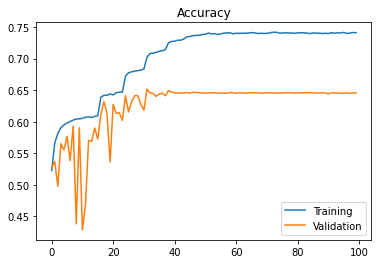

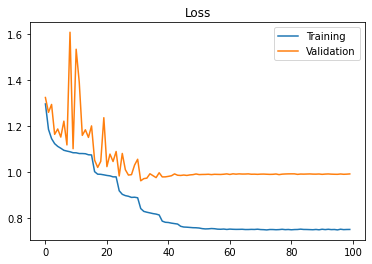

In [11]:
def remove_torch(tensor_list: list) -> list:
    ret = tensor_list.copy()
    for i, _ in enumerate(ret):
        ret[i] = ret[i].item()
    
    return ret

pd_train_loss_per_epoch = pd.Series(train_loss_per_epoch)
pd_valid_loss_per_epoch = pd.Series(valid_loss_per_epoch)
pd_train_acc_per_epoch  = pd.Series(remove_torch(train_acc_per_epoch))
pd_valid_acc_per_epoch  = pd.Series(remove_torch(valid_acc_per_epoch))
loss = pd.concat([pd_train_loss_per_epoch, pd_valid_loss_per_epoch], axis=1)
acc  = pd.concat([pd_train_acc_per_epoch, pd_valid_acc_per_epoch], axis=1)

loss.columns = ['Training', 'Validation']
acc.columns = ['Training', 'Validation']

plt.figure(1)
plt.plot(acc, label=acc.columns)
plt.title('Accuracy')
plt.legend(loc='lower right')
plt.savefig("save/acc.png", dpi=700, format='png')
plt.savefig("save/acc.svg", format='svg')

plt.figure(2)
plt.plot(loss, label=loss.columns)
plt.title('Loss')
plt.legend(loc='upper right')
plt.savefig("save/loss.png", dpi=700, format='png')
plt.savefig("save/loss.svg", format='svg')